# **Trabajo Práctico - Aprendizaje Automático**
# *Integrante: Lucas Demarré*
# *Año: 2023*

# **Importación de liberías y carga de dataset**

## *Complementos*

In [323]:
import os

def limpiar_consola():
    # Verificar si el sistema operativo es Windows o no
    if os.name == 'nt':
        _ = os.system('cls')  # En Windows
    else:
        _ = os.system('clear')  # En sistemas tipo Unix (Linux y macOS)

## *Librerías*

In [421]:
# Liberías
# Análisis descriptivo
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn import preprocessing
from prettytable import PrettyTable
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Regresión Lineal Múltiple
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Regresión Logística
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

# Redes Neuronales
import optuna
import tensorflow as tf
from keras.layers import Dense, Dropout 
from keras.models import Sequential
from keras.callbacks import Callback
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## *Carga de dataset*

In [325]:
# Cargamos el Dataset
dataset = pd.read_csv('weatherAUS.csv')
dataset.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


# **Análisis descriptivo**

## *Exploración de los datos*

### **Filtramos los datos que nos interesan**

In [326]:
# Creamos una lista con las ubicaciones de interés
interest_locations = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']

# Filtramos el dataset para incluir solo las ubicaciones de interés
data = dataset[dataset['Location'].isin(interest_locations)]

# Eliminamos la primera columa llamada 'Unnamed: 0', ya que esta no nos proporciona ningún dato relevante para el problema
data = data.drop('Unnamed: 0', axis=1)

# Restablecemos el índice del DataFrame después de la filtración
data.reset_index(drop=True, inplace=True)

# Vemos el dataframe filtrado
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
1,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
2,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
3,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
4,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


### **Vemos que tipos de datos contiene cada columna**

#### *Variables numéricas*

In [327]:
# Columnas con variables numéricas
numerical_feature = [feature for feature in data.columns if data[feature].dtypes != 'O']

# Columnas con variables discretas
discrete_feature = [feature for feature in numerical_feature if len(data[feature].unique()) < 25]

# Columnas con variables continuas
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]

# Creamos una tabla
tabla_numericas = PrettyTable(['Columnas Discretas', 'Columnas Continuas'])

# Agregamos las filas
max_length = max(len(discrete_feature), len(continuous_feature))

for i in range(max_length):
    feature_discreta = discrete_feature[i] if i < len(discrete_feature) else ''
    feature_continua = continuous_feature[i] if i < len(continuous_feature) else ''

    tabla_numericas.add_row([feature_discreta, feature_continua])

# Mostramos la tabla
print(f'Columnas con Variables Numéricas: {len(numerical_feature)}\n')
print(tabla_numericas)

Columnas con Variables Numéricas: 17

+--------------------+--------------------+
| Columnas Discretas | Columnas Continuas |
+--------------------+--------------------+
|      Cloud9am      |      MinTemp       |
|      Cloud3pm      |      MaxTemp       |
|                    |      Rainfall      |
|                    |    Evaporation     |
|                    |      Sunshine      |
|                    |   WindGustSpeed    |
|                    |    WindSpeed9am    |
|                    |    WindSpeed3pm    |
|                    |    Humidity9am     |
|                    |    Humidity3pm     |
|                    |    Pressure9am     |
|                    |    Pressure3pm     |
|                    |      Temp9am       |
|                    |      Temp3pm       |
|                    |  RainfallTomorrow  |
+--------------------+--------------------+


#### *Variables categóricas*

In [328]:
# Variables categóricas
categorical_feature = [feature for feature in data.columns if feature not in numerical_feature]

# Creamos una tabla
table = PrettyTable(['Variables Categóricas'])

# Agregamos las filas
for columna in categorical_feature: table.add_row([columna])

# Imprimir la tabla
print(table)

+-----------------------+
| Variables Categóricas |
+-----------------------+
|          Date         |
|        Location       |
|      WindGustDir      |
|       WindDir9am      |
|       WindDir3pm      |
|       RainToday       |
|      RainTomorrow     |
+-----------------------+


### **Detectamos si hay datos faltantes**

#### *Conteo de datos faltantes*

In [329]:
# Guardamos la cantidad de datos que contiene el dataset
dataset_size = data.shape

# Mostramos el tamaño
print(f'Cantidad de datos: {dataset_size[0]}')

# Mostramos de una forma numérica
print(f'{data.isnull().sum()}\n')

Cantidad de datos: 15986
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64



#### *Gráfico del conteo*

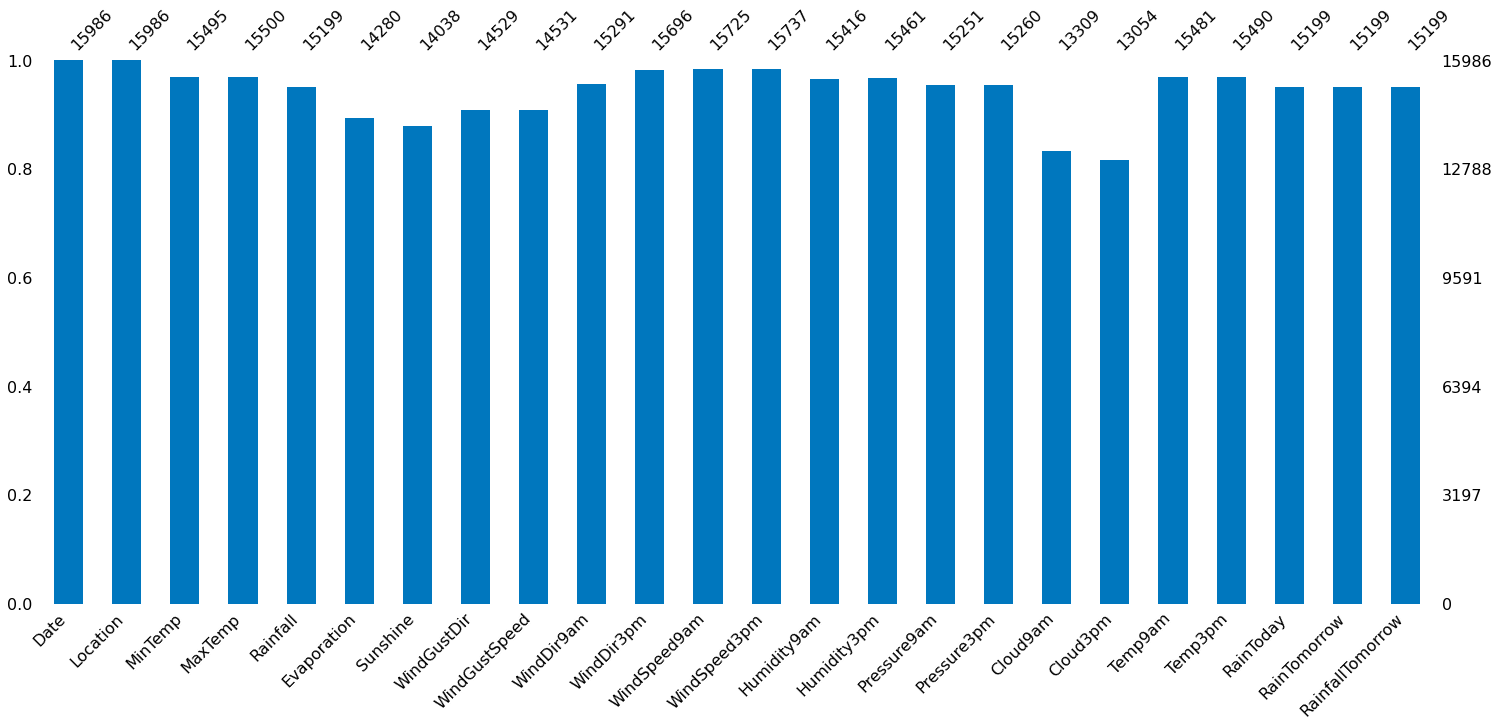

In [330]:
# Gráficamos la cantidad de datos que tiene cada columna para verificar datos faltantes
msno.bar(data, color='#0077be')

## *Rellenamos los datos faltantes*

### **Datos faltantes numéricos**

#### *Datos continuos*

In [331]:
# Cambiamos todos los valores faltantes numéricos por la mediana
for features in continuous_feature:
    if(data[features].isnull().sum() > 0): data[features] = data[features].fillna(data[features].median())

# Mostramos de una forma numérica
print(f'{data.isnull().sum()}\n')

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
WindGustDir         1457
WindGustSpeed          0
WindDir9am           695
WindDir3pm           290
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am            2677
Cloud3pm            2932
Temp9am                0
Temp3pm                0
RainToday            787
RainTomorrow         787
RainfallTomorrow       0
dtype: int64



#### *Datos discretos*

In [332]:
# Cambiamos todos los valores faltantes discretos por la moda
for features in discrete_feature:
    if data[features].isnull().sum() > 0: data[features] = data[features].fillna(data[features].mode()[0])

# Mostramos de una forma numérica
print(f'{data.isnull().sum()}\n')

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
WindGustDir         1457
WindGustSpeed          0
WindDir9am           695
WindDir3pm           290
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
RainToday            787
RainTomorrow         787
RainfallTomorrow       0
dtype: int64



### **Datos faltantes categóricos**

In [333]:
# Convertimos las columnas categóricas restantes a numéricos ('Date' y 'Location' no tienen valores faltantes y en 'RainToday' y 'RainTomorrow' vamos a usar otro método)
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10, 'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10, 'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10, 'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
location = { 'Sydney': 1, 'SydneyAirport': 2, 'MelbourneAirport': 3, 'Melbourne': 4, 'Canberra': 5}

# Los reemplazamos en el dataset
data['WindGustDir'] = data['WindGustDir'].map(windgustdir)
data['WindDir9am'] = data['WindDir9am'].map(winddir9am)
data['WindDir3pm'] = data['WindDir3pm'].map(winddir3pm)
data["Location"] = data["Location"].map(location)

# Reemplazamos en las columnas 'RainToday' y 'RainTomorrow' los 'Yes' por 1 y los 'No' por 0
data['RainToday'] = pd.get_dummies(data['RainToday'], drop_first = True)
data['RainTomorrow'] = pd.get_dummies(data['RainTomorrow'], drop_first = True)

# Reemplazamos las columnas restante ('WindGustDir', 'WindDir9am' y 'WindDir3pm')
for features in categorical_feature:
    if(data[features].isnull().sum() > 0):
        data[features] = data[features].fillna(data[features].mode()[0])

# Mostramos de una forma numérica
print(f'{data.isnull().sum()}\n')

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64



## *Solucionamos los outliers (columnas continuas)*

### **Mostramos los gráficos con outliers**

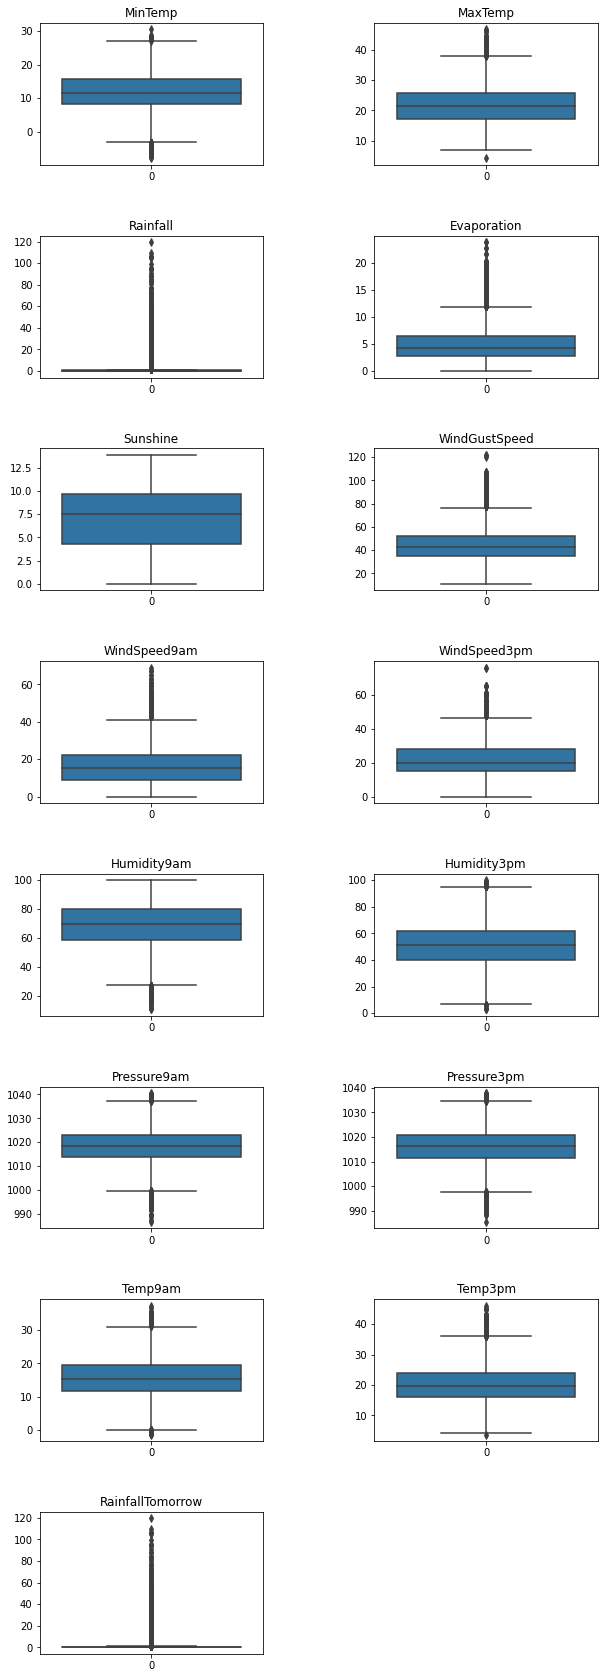

In [334]:
# Definimos el número de columnas en el grid
num_cols = 2

# Calculamos el número de filas y columnas necesarias
num_rows = (len(continuous_feature) + num_cols - 1) // num_cols

# Creamos un grid de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 30))

# Iteramos sobre las columnas continuas y hacemos un gráfico de caja para cada una
for i, feature in enumerate(continuous_feature):
    row = i // num_cols
    col = i % num_cols

    sns.boxplot(data[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

# Como la cantidad de columnas continuas es impar, ocultamos el último eje vacío que queda por esto
if len(continuous_feature) % 2 == 1: fig.delaxes(axes[-1, -1])

# Ajustamos el diseño para evitar solapamientos y agregamos espacio entre los gráficos
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Mostramos los gráficos
plt.show()

### **Solucionamos los outliers**

In [335]:
# Creamos una tabla para una mejor visualización
table = PrettyTable()
table.field_names = ['Características', 'Lower Bridge', 'Upper Bridge']

# Iteramos sobre cada característica continua para resolver los outliers
for feature in continuous_feature:
    # Calculamos el Rango Intercuartílico de la característica
    IQR = data[feature].quantile(0.75) - data[feature].quantile(0.25)

    # Caculamos los límites tanto inferiores como superiores para delimitar los valores atípicos
    lower_bridge = data[feature].quantile(0.25) - (IQR * 1.5)
    upper_bridge = data[feature].quantile(0.75) + (IQR * 1.5)

    # Igualamos todos aquellos valores que esten fuera de estos límites al propio límite
    data.loc[data[feature] >= upper_bridge, feature] = upper_bridge
    data.loc[data[feature] <= lower_bridge, feature] = lower_bridge

    # Agregamos la fila a la tabla para su visualización
    table.add_row([feature, round(lower_bridge, 2), round(upper_bridge, 2)])

# Imprimimos la tabla
print(table)

+------------------+--------------+--------------+
| Características  | Lower Bridge | Upper Bridge |
+------------------+--------------+--------------+
|     MinTemp      |     -3.3     |     27.1     |
|     MaxTemp      |     4.85     |    38.05     |
|     Rainfall     |     -0.9     |     1.5      |
|   Evaporation    |     -2.6     |     11.8     |
|     Sunshine     |    -3.74     |    17.76     |
|  WindGustSpeed   |     9.5      |     77.5     |
|   WindSpeed9am   |    -10.5     |     41.5     |
|   WindSpeed3pm   |     -4.5     |     47.5     |
|   Humidity9am    |     27.5     |    111.5     |
|   Humidity3pm    |     7.0      |     95.0     |
|   Pressure9am    |    999.6     |    1037.2    |
|   Pressure3pm    |    997.55    |   1034.75    |
|     Temp9am      |     0.15     |    30.95     |
|     Temp3pm      |     4.0      |     36.0     |
| RainfallTomorrow |     -0.9     |     1.5      |
+------------------+--------------+--------------+


### **Mostramos nuevamente los gráficos pero sin outliers**

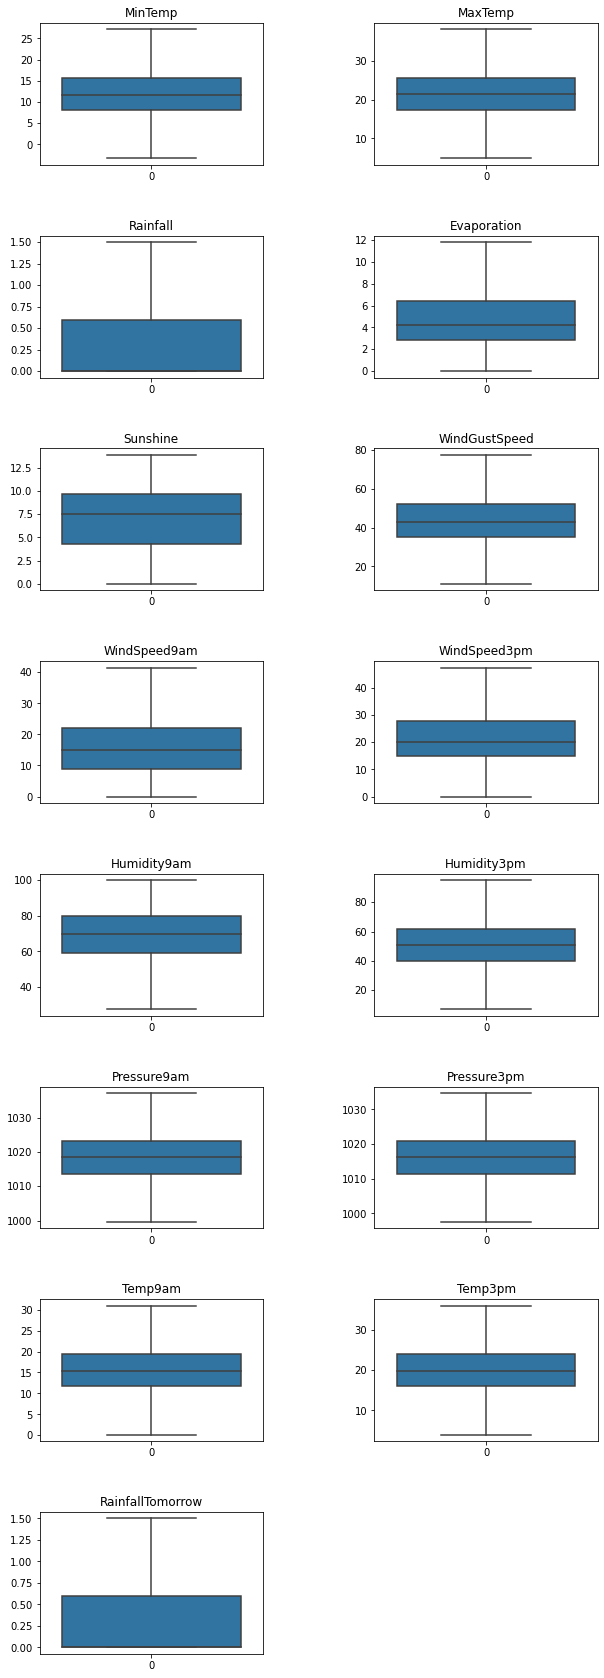

In [336]:
# Definimos el número de columnas en el grid
num_cols = 2

# Calculamos el número de filas y columnas necesarias
num_rows = (len(continuous_feature) + num_cols - 1) // num_cols

# Creamos un grid de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 30))

# Iteramos sobre las columnas continuas y hacemos un gráfico de caja para cada una
for i, feature in enumerate(continuous_feature):
    row = i // num_cols
    col = i % num_cols

    sns.boxplot(data[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

# Como la cantidad de columnas continuas es impar, ocultamos el último eje vacío que queda por esto
if len(continuous_feature) % 2 == 1: fig.delaxes(axes[-1, -1])

# Ajustamos el diseño para evitar solapamientos y agregamos espacio entre los gráficos
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Mostramos los gráficos
plt.show()

## *Balanceo del dataset*

### **Verificación de balanceo**

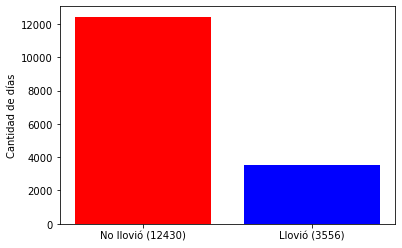

In [337]:
# Creamos las variables que cuentan la cantidad de veces que aparecen en el dataset cada tipo de variable
# 0: No llovió. 1: Llovió.
rain_count = data[data['RainTomorrow'] == 1]['RainTomorrow'].size
no_rain_count = data[data['RainTomorrow'] == 0]['RainTomorrow'].size

# Creamos el gráfico de la variable 'RainTomorrow' para ver su balanceo
plt.bar(['No llovió (%d)' % no_rain_count, 'Llovió (%d)' % rain_count], [no_rain_count, rain_count], color = ['red', 'blue'], width= .8)
plt.ylabel('Cantidad de días')

# Mostramos el gráfico
plt.show()

### **Balanceamos el dataset**

In [338]:
# Separammos las características (X) y variable objetivo (y)
X = data.drop('RainTomorrow', axis=1)
y = data['RainTomorrow']

# Inicializamos el objeto RandomOverSampler
ros = RandomOverSampler(random_state=0)

# Aplicamos el sobremuestreo a los datos
X_resampled, y_resampled = ros.fit_resample(X, y)

# Creamos un nuevo DataFrame con los datos sobremuestreados
data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='RainTomorrow')], axis=1)

### **Verificamos nuevamente el balance**

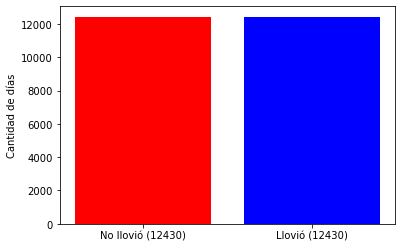

In [339]:
# Creamos las variables que cuentan la cantidad de veces que aparecen en el dataset cada tipo de variable
# 0: No llovió. 1: Llovió.
rain_count = data_resampled[data_resampled['RainTomorrow'] == 1]['RainTomorrow'].size
no_rain_count = data_resampled[data_resampled['RainTomorrow'] == 0]['RainTomorrow'].size

# Creamos el gráfico de la variable 'RainTomorrow' para ver su balanceo
plt.bar(['No llovió (%d)' % no_rain_count, 'Llovió (%d)' % rain_count], [no_rain_count, rain_count], color = ['red', 'blue'], width= .8)
plt.ylabel('Cantidad de días')

# Mostramos el gráfico
plt.show()

## *Estandarización*

### **Gráficamos para ver las variables numéricas antes de la estandarización**

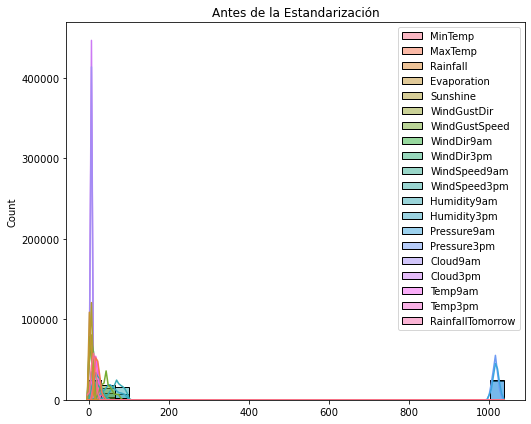

In [340]:
# Elegimos las columnas que no son numéricas
# 'Date' y 'Location' son categóricas no discretizadas. 'RainTomorrow' y 'RainToday' son binarias discretizadas.
discarded_columns = ['Date', 'Location', 'RainTomorrow', 'RainToday']

# Creamos el gráfico
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=data_resampled.drop(discarded_columns, axis=1), bins=30, kde=True)
plt.title('Antes de la Estandarización')

# Lo mostramos
plt.tight_layout()
plt.show()

### **Estandarizamos los datos con StandardScaler**

In [341]:
# Estandarizamos con StandardScaler las variables numéricas
standarScaler = preprocessing.StandardScaler().fit_transform(data_resampled.drop(discarded_columns, axis=1))

# Creamos un nuevo Dataframe con los numpyArray que nos vuelve la estandarización
standarScalerDF = pd.DataFrame(standarScaler, columns=data_resampled.drop(discarded_columns, axis=1).columns)

# Seleccionamos solo las columnas faltantes en el Dataframe estandarizado recien creado.
# Esto es para que a la hora de concatenar, no nos interpole los datos y nos elimine la estandarización.
missing_columns = data_resampled[discarded_columns]

# Concatenamos tanto el Dataframe estandarizado con las columnas faltantes ('Date', 'Location', 'RainToday' y 'RainTomorrow')
final_dataset = pd.concat([missing_columns, standarScalerDF], axis=1)

### **Volvemos a gráficar las variables numéricas**

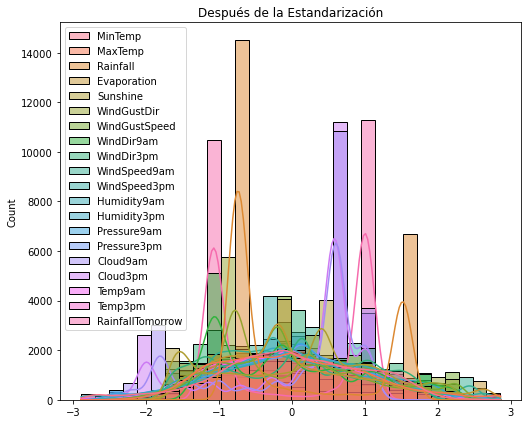

In [342]:
# Creamos el gráfico
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=final_dataset.drop(discarded_columns, axis=1), bins=30, kde=True)
plt.title('Después de la Estandarización')

# Mostramos el gráfico
plt.tight_layout()
plt.show()

## *Visualización de datos*

### **Datos numéricos**

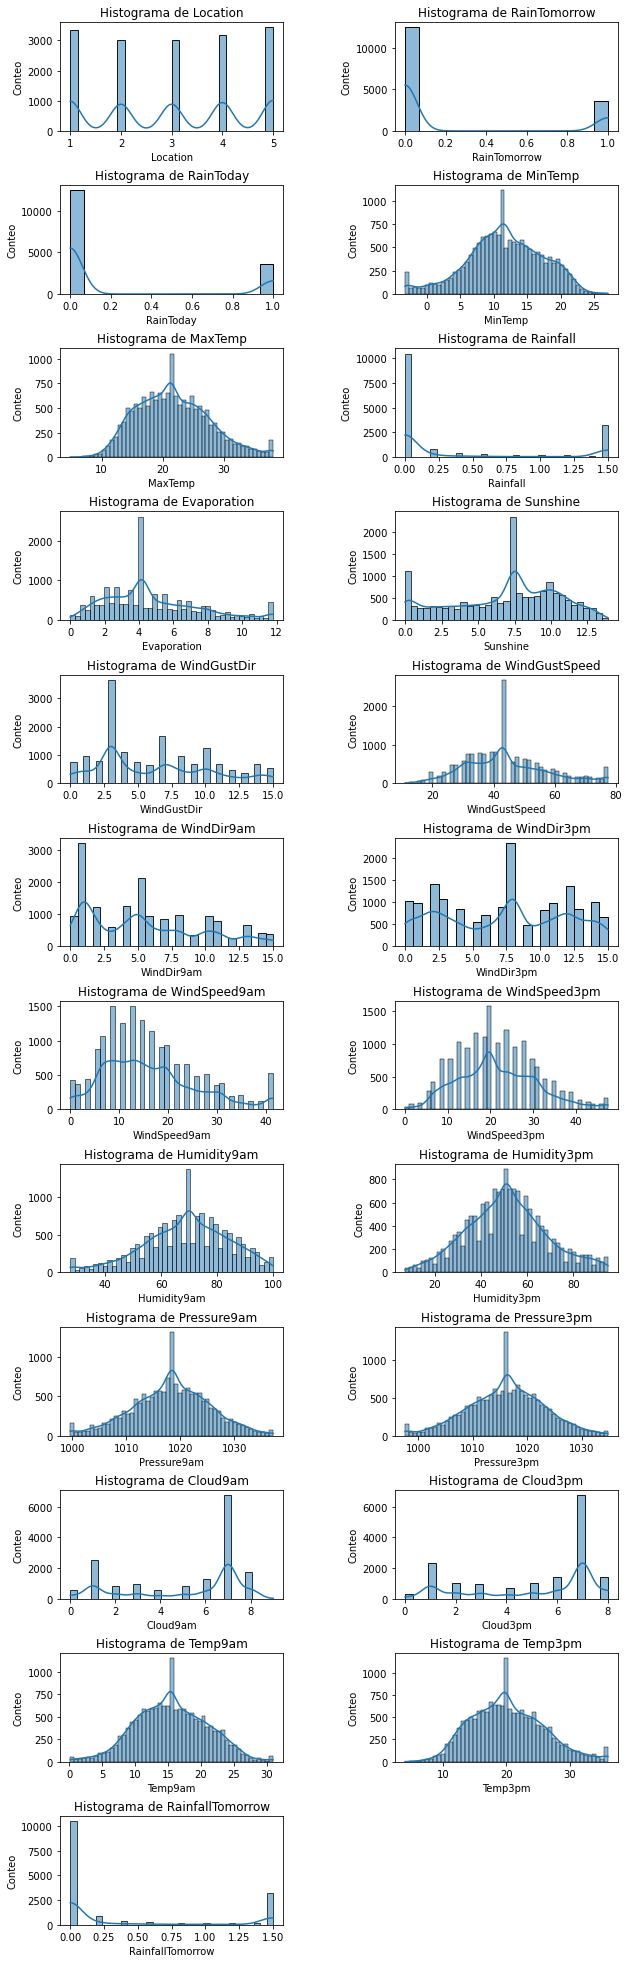

In [343]:
# Columnas con variables numéricas
numerical_feature_resampled = [feature for feature in final_dataset.columns if data[feature].dtypes != 'O']

# Definimos el número de columnas en el grid
num_cols = 2

# Calculamos el número de filas y columnas necesarias
num_rows = (len(numerical_feature_resampled) + num_cols - 1) // num_cols

# Creamos un grid de subgráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 35))

# Iteramos sobre las variables numéricas y hacemos un gráfico de distribución para cada una
for i, feature in enumerate(numerical_feature_resampled):
    row = i // num_cols
    col = i % num_cols

    sns.histplot(data[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Histograma de {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Conteo')

# Como la cantidad de variables numéricas es impar, ocultamos el último eje vacío que queda por esto
if len(numerical_feature_resampled) % 2 == 1: fig.delaxes(axes[-1, -1])

# Ajustamos el diseño para evitar solapamientos y agregamos espacio entre los gráficos
plt.subplots_adjust(hspace=.5, wspace=.5)

# Mostramos los gráficos
plt.show()

### **Datos categóricos**

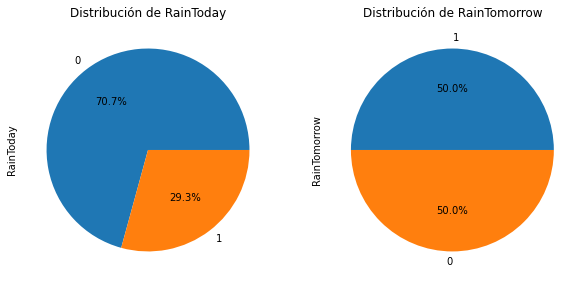

In [344]:
# Creamos un subgráfico para cada figura
fig, axes = plt.subplots(1, 2, figsize=(10, 20))

# Solo elegimos las columnas 'RainToday' y 'RainTomorrow' porque son las
# únicas columnas categóricas que nos pueden mostrar información relevante para el problema
for i, feature in enumerate(['RainToday', 'RainTomorrow']):
    # Contabilizamos la cantidad de valores en cada característica para graficarlo en un gráfico de sectores o 'torta'
    final_dataset[feature].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[i])
    axes[i].set_title(f'Distribución de {feature}')

# Mostramos los gráficos
plt.show()

En el caso de 'RainToday', como no es una variable en estudio importante por ahora, no se hizo su balance como si en 'RainTomorrow'.

## *Matriz de Correlación y elección de características*

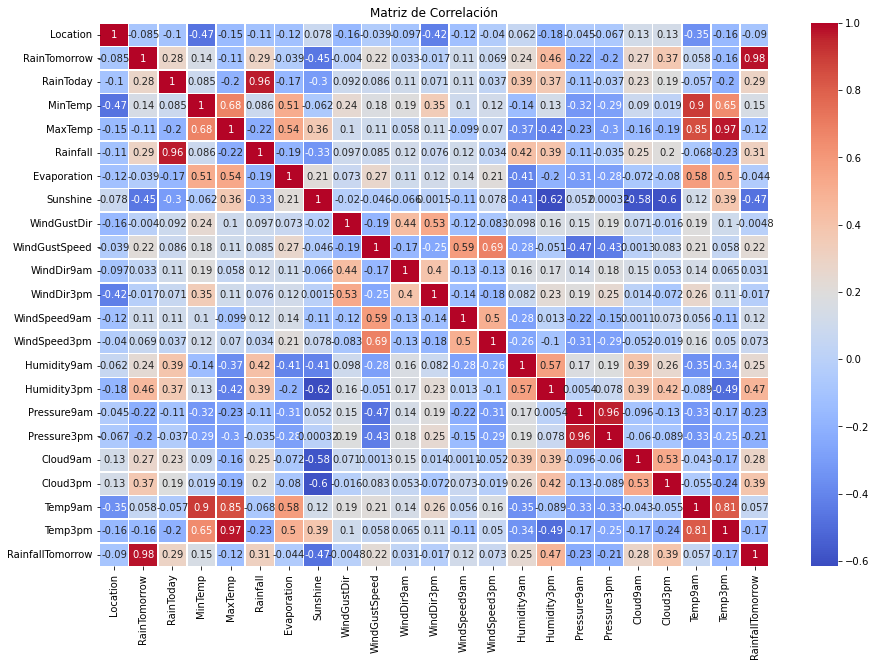

In [345]:
# Calculamos la matriz de correlación
correlation_matrix = final_dataset.corr(method = 'pearson')

# Creamos una visualización de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

Las únicas características que excluiremos son las siguientes:

* 'Date': ya que solo proporciona información sobre el día en que llovió, pero el día no es relevante para los modelos.
* La variable del 'futuro' (RainfallTomorrow y RainTomorrow): también excluiremos, lógicamente, las variables que estamos precidiendo y que, por consecuencia, son datos dados de un 'futuro'. Datos que, en un entorno real, no lo tendríamos sino que tendríamos que predecirlos.

# **Modelos**

In [346]:
# Seleccionamos solo las columnas deseadas para los modelos donde predecimos 'RainTomorrow'
X_rain = final_dataset.drop(['Date', 'RainTomorrow', 'RainfallTomorrow'], axis=1).astype('float32')
Y_rain = final_dataset['RainTomorrow'].astype('float32')

# Seleccionamos solo las columnas deseadas para los modelos donde predecimos 'RainfallTomorrow'
X_rainfall = final_dataset.drop(['Date', 'RainfallTomorrow', 'RainTomorrow'], axis=1).astype('float32')
Y_rainfall = final_dataset['RainfallTomorrow'].astype('float32')

## *Modelos Base*

### **Clasificación (RainTomorrow)**

In [347]:
## Criterio ingenuo:
# Si hoy llovió, mañana no llueve

# Creamos un DataFrame para guardar las predicciones
predictions_rain = pd.DataFrame(columns=['RainTomorrow'])

# Recorreremos cada fila de nuestros datos
for index, row in X_rain.iterrows():
    # Accedemos al valor de 'RainToday'
    rainToday = row['RainToday']
    
    # Aplicamos la condición
    if rainToday == 0:
        # Agregamos la fila indicando que va a llover mañana
        predictions_rain = predictions_rain.append({'RainTomorrow': '1'}, ignore_index=True)
    else:
        # Agregamos la fila indicando que no va a llover mañana
        predictions_rain = predictions_rain.append({'RainTomorrow': '0'}, ignore_index=True)

# Convertimos las predicciones a float32
predictions_rain = predictions_rain.astype('float32')

# Calculamos las métricas
accuracy = accuracy_score(Y_rain, predictions_rain)
f1_0 = f1_score(Y_rain, predictions_rain, pos_label=0)
f1_1 = f1_score(Y_rain, predictions_rain, pos_label=1)
        
# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['Accuracy', f'{accuracy:.5f}'])
table.add_row(['F1-Score (Clase 0)', f'{f1_0:.5f}'])
table.add_row(['F1-Score (Clase 1', f'{f1_1:.5f}'])

# Mostramos la tabla
print(table)

+--------------------+---------+
|      Métrica       |  Valor  |
+--------------------+---------+
|      Accuracy      | 0.37369 |
| F1-Score (Clase 0) | 0.20981 |
| F1-Score (Clase 1  | 0.48128 |
+--------------------+---------+


### **Regresión (RainfallTomorrow)**

In [348]:
## Regresión lineal simple:
# Vamos a hacer una regresión lineal pero con una única variable, con 'Sunshine'

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rainfall['Sunshine'].values.reshape(-1, 1), Y_rainfall, test_size=0.2, random_state=0)

# Creamos una instancia del modelo de Regresión Lineal
linear_model = LinearRegression()

# Lo entrenamos
linear_model.fit(X_train, Y_train)

# Realizamos predicciones en los datos de prueba
Y_pred = linear_model.predict(X_test)

# Calculamos las métricas
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['R2', f'{r2:.5f}'])
table.add_row(['MSE', f'{mse:.5f}'])
table.add_row(['MAE', f'{mae:.5f}'])

# Mostramos la tabla
print(table)

+---------+---------+
| Métrica |  Valor  |
+---------+---------+
|    R2   | 0.21692 |
|   MSE   | 0.78119 |
|   MAE   | 0.77711 |
+---------+---------+


## *Regresión Lineal Múltiple*

### **Método LinearRegression**

#### *RainTomorrow*

In [298]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rain, Y_rain, test_size=0.2, random_state=0)

# Creamos una instancia del modelo de Regresión Lineal
linear_model = LinearRegression()

# Lo entrenamos
linear_model.fit(X_train, Y_train)

# Realizamos predicciones en los datos de prueba
Y_pred = linear_model.predict(X_test)

# Convertimos las predicciones en 1 si es mayor a 0.5 y 0 en caso contrario
Y_pred = [1 if pred > 0.5 else 0 for pred in Y_pred]

# Calculamos las métricas
accuracy = accuracy_score(Y_test, Y_pred)
f1_0 = f1_score(Y_test, Y_pred, pos_label=0)
f1_1 = f1_score(Y_test, Y_pred, pos_label=1)
        
# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['Accuracy', f'{accuracy:.5f}'])
table.add_row(['F1-Score (Clase 0)', f'{f1_0:.5f}'])
table.add_row(['F1-Score (Clase 1', f'{f1_1:.5f}'])

# Mostramos la tabla
print(table)

+--------------------+---------+
|      Métrica       |  Valor  |
+--------------------+---------+
|      Accuracy      | 0.75704 |
| F1-Score (Clase 0) | 0.76406 |
| F1-Score (Clase 1  | 0.74959 |
+--------------------+---------+


#### *RainfallTomorrow*

In [295]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rainfall, Y_rainfall, test_size=0.2, random_state=0)

# Creamos una instancia del modelo de Regresión Lineal
linear_model = LinearRegression()

# Lo entrenamos
linear_model.fit(X_train, Y_train)

# Realizamos predicciones en los datos de prueba
Y_pred = linear_model.predict(X_test)

# Calculamos las métricas
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['R2', f'{r2:.3f}'])
table.add_row(['MSE', f'{mse:.3f}'])
table.add_row(['MAE', f'{mae:.3f}'])

# Mostramos la tabla
print(table)

+---------+-------+
| Métrica | Valor |
+---------+-------+
|    R2   | 0.363 |
|   MSE   | 0.635 |
|   MAE   | 0.666 |
+---------+-------+


### **Métodos de Gradiente Descendiente**

#### *Gradiente descendiente*

##### **Función**

In [299]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

##### **RainTomorrow**

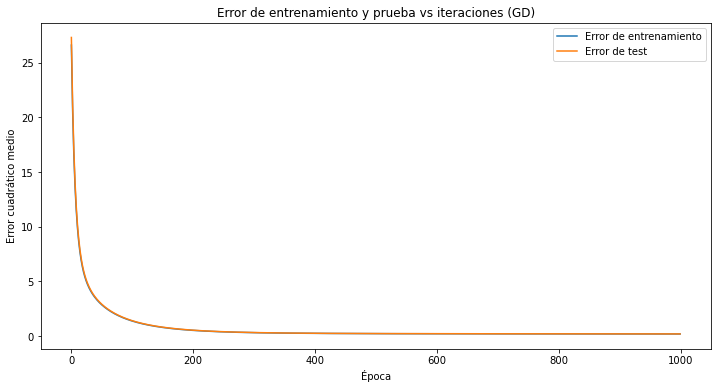

+--------------------+---------+
|      Métrica       |  Valor  |
+--------------------+---------+
|      Accuracy      | 0.72848 |
| F1-Score (Clase 0) | 0.73341 |
| F1-Score (Clase 1  | 0.72336 |
+--------------------+---------+


In [300]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rain, Y_rain.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Entrenamos el modelo de gradiente descendente
model = gradient_descent(X_train, Y_train, X_test, Y_test, lr=0.01, epochs=1000)

# Función para calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    # Verificamos si hay ceros en y_true y ajustar según corresponda
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calculamos MAPE solo para las observaciones donde y_true no es cero
    if len(y_true_masked) > 0:
        mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    else:
        mape = 0  # Si no hay observaciones válidas, se establece MAPE en cero.

    return mape

# Calculamos las métricas para el modelo
Y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), model)

# Convertimos las predicciones en 1 si es mayor a 0.5 y 0 en caso contrario
Y_pred = [1 if pred > 0.5 else 0 for pred in Y_pred]

# Calculamos las métricas
accuracy = accuracy_score(Y_test, Y_pred)
f1_0 = f1_score(Y_test, Y_pred, pos_label=0)
f1_1 = f1_score(Y_test, Y_pred, pos_label=1)
        
# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['Accuracy', f'{accuracy:.5f}'])
table.add_row(['F1-Score (Clase 0)', f'{f1_0:.5f}'])
table.add_row(['F1-Score (Clase 1', f'{f1_1:.5f}'])

# Mostramos la tabla
print(table)

##### **RainfallTomorrow**

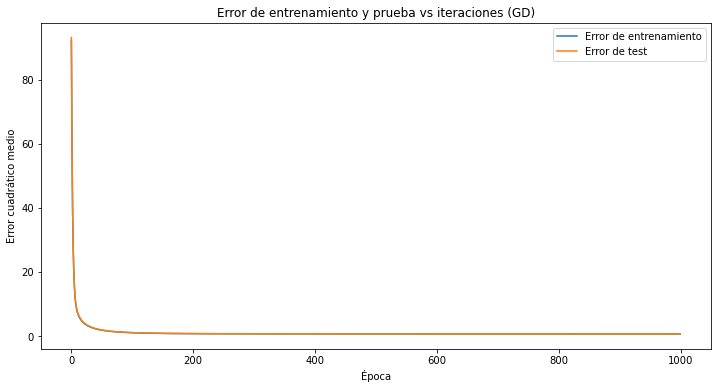

+---------+--------+
| Métrica | Valor  |
+---------+--------+
|    R2   | 0.329  |
|   MSE   | 0.669  |
|   RMSE  | 0.818  |
|   MAE   | 0.679  |
|   MAPE  | 81.162 |
+---------+--------+


In [301]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rainfall, Y_rainfall.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Entrenamos el modelo de gradiente descendente
model = gradient_descent(X_train, Y_train, X_test, Y_test, lr=0.01, epochs=1000)

# Función para calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    # Verificar si hay ceros en y_true y ajustar según corresponda
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calcular MAPE solo para las observaciones donde y_true no es cero
    if len(y_true_masked) > 0:
        mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    else:
        mape = 0  # Si no hay observaciones válidas, se establece MAPE en cero.

    return mape

# Calculamos las métricas para el modelo
Y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), model)

R2 = r2_score(Y_test, Y_pred)
MSE = mean_squared_error(Y_test, Y_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(Y_test, Y_pred)
MAPE = mean_absolute_percentage_error(Y_test, Y_pred)

# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['R2', f'{R2:.3f}'])
table.add_row(['MSE', f'{MSE:.3f}'])
table.add_row(['RMSE', f'{RMSE:.3f}'])
table.add_row(['MAE', f'{MAE:.3f}'])
table.add_row(['MAPE', f'{MAPE:.3f}'])

# Mostramos la tabla
print(table)

#### *Gradiente descendiente estocástico*

##### **Función**

In [302]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=4096):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote aleatorio para hacer SGD
            X_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]

            predictions = np.matmul(X_batch, W)
            errors = y_batch - predictions
            train_mse = np.mean(errors ** 2)
            train_errors.append(train_mse)

            gradients = -2 * np.matmul(X_batch.T, errors) / batch_size

            W = W - (lr * gradients)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD con Batch Size)')
    plt.show()

    return W


##### **RainTomorrow**

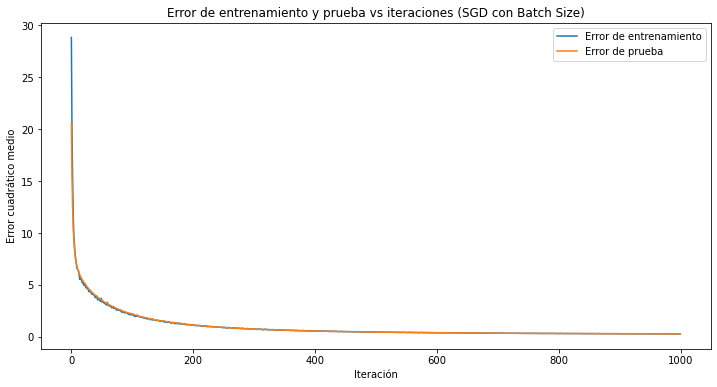

+--------------------+---------+
|      Métrica       |  Valor  |
+--------------------+---------+
|      Accuracy      | 0.66814 |
| F1-Score (Clase 0) | 0.68809 |
| F1-Score (Clase 1  | 0.64547 |
+--------------------+---------+


In [303]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rain, Y_rain.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Entrenamos el modelo
model = stochastic_gradient_descent(X_train, Y_train, X_test, Y_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo
Y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), model)

# Convertimos las predicciones en 1 si es mayor a 0.5 y 0 en caso contrario
Y_pred = [1 if pred > 0.5 else 0 for pred in Y_pred]

# Calculamos las métricas
accuracy = accuracy_score(Y_test, Y_pred)
f1_0 = f1_score(Y_test, Y_pred, pos_label=0)
f1_1 = f1_score(Y_test, Y_pred, pos_label=1)
        
# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['Accuracy', f'{accuracy:.5f}'])
table.add_row(['F1-Score (Clase 0)', f'{f1_0:.5f}'])
table.add_row(['F1-Score (Clase 1', f'{f1_1:.5f}'])

# Mostramos la tabla
print(table)

##### **RainfallTomorrow**

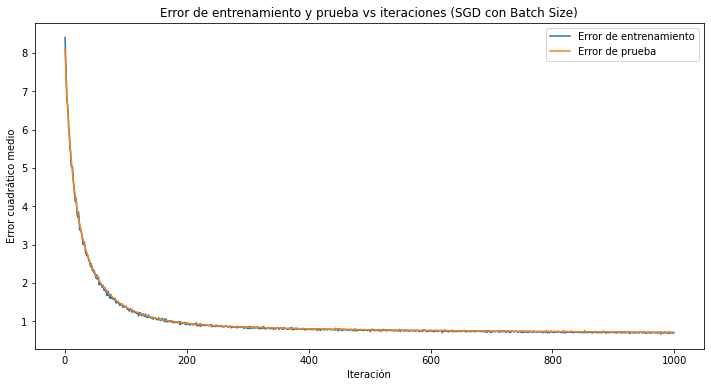

+---------+--------+
| Métrica | Valor  |
+---------+--------+
|    R2   | 0.289  |
|   MSE   | 0.710  |
|   RMSE  | 0.842  |
|   MAE   | 0.699  |
|   MAPE  | 84.759 |
+---------+--------+


In [304]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rainfall, Y_rainfall.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Entrenamos el modelo
model = stochastic_gradient_descent(X_train, Y_train, X_test, Y_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo
Y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), model)

R2 = r2_score(Y_test, Y_pred)
MSE = mean_squared_error(Y_test, Y_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(Y_test, Y_pred)
MAPE = mean_absolute_percentage_error(Y_test, Y_pred)

# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['R2', f'{R2:.3f}'])
table.add_row(['MSE', f'{MSE:.3f}'])
table.add_row(['RMSE', f'{RMSE:.3f}'])
table.add_row(['MAE', f'{MAE:.3f}'])
table.add_row(['MAPE', f'{MAPE:.3f}'])

# Mostramos la tabla
print(table)

#### *Gradiente descendiente mini-batch*

##### **Función**

In [305]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=4096):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

##### **RainTomorrow**

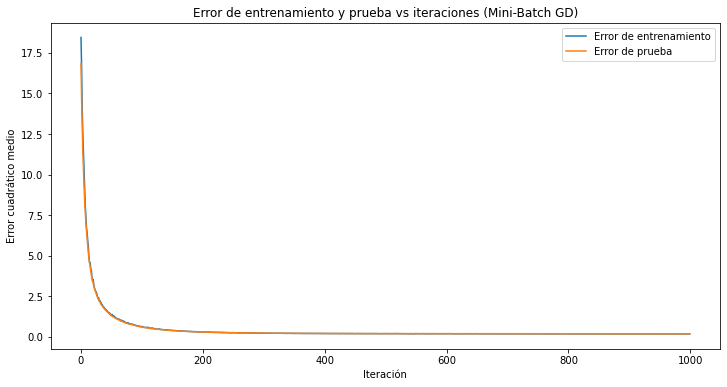

+--------------------+---------+
|      Métrica       |  Valor  |
+--------------------+---------+
|      Accuracy      | 0.73290 |
| F1-Score (Clase 0) | 0.73910 |
| F1-Score (Clase 1  | 0.72641 |
+--------------------+---------+


In [306]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rain, Y_rain.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Entrenamos el modelo
model = mini_batch_gradient_descent(X_train, Y_train, X_test, Y_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo
Y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), model)

# Convertimos las predicciones en 1 si es mayor a 0.5 y 0 en caso contrario
Y_pred = [1 if pred > 0.5 else 0 for pred in Y_pred]

# Calculamos las métricas
accuracy = accuracy_score(Y_test, Y_pred)
f1_0 = f1_score(Y_test, Y_pred, pos_label=0)
f1_1 = f1_score(Y_test, Y_pred, pos_label=1)
        
# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['Accuracy', f'{accuracy:.5f}'])
table.add_row(['F1-Score (Clase 0)', f'{f1_0:.5f}'])
table.add_row(['F1-Score (Clase 1', f'{f1_1:.5f}'])

# Mostramos la tabla
print(table)

##### **RainfallTomorrow**

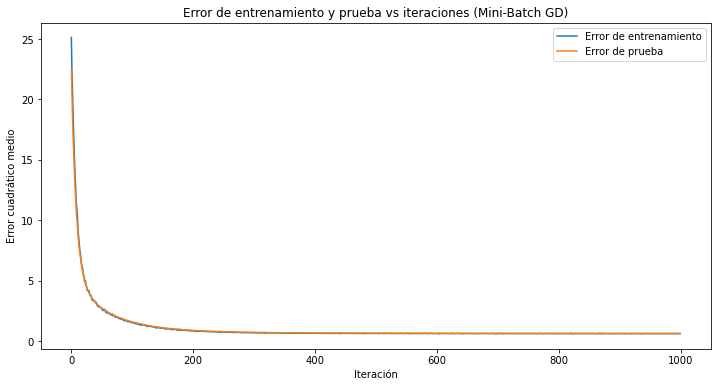

+---------+--------+
| Métrica | Valor  |
+---------+--------+
|    R2   | 0.350  |
|   MSE   | 0.648  |
|   RMSE  | 0.805  |
|   MAE   | 0.671  |
|   MAPE  | 80.020 |
+---------+--------+


In [307]:
# Separamos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_rainfall, Y_rainfall.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Entrenamos el modelo
model = mini_batch_gradient_descent(X_train, Y_train, X_test, Y_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo
Y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), model)

# Calculamos las métricas
R2 = r2_score(Y_test, Y_pred)
MSE = mean_squared_error(Y_test, Y_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(Y_test, Y_pred)
MAPE = mean_absolute_percentage_error(Y_test, Y_pred)

# Creamos una tabla
table = PrettyTable(['Métrica', 'Valor'])

# Agregamos las filas a la tabla
table.add_row(['R2', f'{R2:.3f}'])
table.add_row(['MSE', f'{MSE:.3f}'])
table.add_row(['RMSE', f'{RMSE:.3f}'])
table.add_row(['MAE', f'{MAE:.3f}'])
table.add_row(['MAPE', f'{MAPE:.3f}'])

# Mostramos la tabla
print(table)

### **Regularización**

#### *RainTomorrow*

In [313]:
# Separamos los datos en conjuntos de entrenamiento y prueba para RainTomorrow
X_train, X_test, Y_train, Y_test = train_test_split(X_rain, Y_rain.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Creamos instancias de los modelos de regularización
lasso_model = Lasso(alpha=1.0)
ridge_model = Ridge(alpha=1.0)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Entrenamos los modelos de regularización con los datos de entrenamiento
lasso_model.fit(X_train, Y_train)
ridge_model.fit(X_train, Y_train)
elasticnet_model.fit(X_train, Y_train)

# Realizamos predicciones en los datos de prueba
Y_pred_lasso = lasso_model.predict(X_test)
Y_pred_ridge = ridge_model.predict(X_test)
Y_pred_elasticnet = elasticnet_model.predict(X_test)

# Convertimos las predicciones en 1 si es mayor a 0.5 y 0 en caso contrario
Y_pred_lasso = [1 if pred > 0.5 else 0 for pred in Y_pred_lasso]
Y_pred_ridge = [1 if pred > 0.5 else 0 for pred in Y_pred_ridge]
Y_pred_elasticnet = [1 if pred > 0.5 else 0 for pred in Y_pred_elasticnet]

# Calculamos las métricas para cada modelo
accuracy_lasso = accuracy_score(Y_test, Y_pred_lasso)
f1_0_lasso = f1_score(Y_test, Y_pred_lasso, pos_label=0)
f1_1_lasso = f1_score(Y_test, Y_pred_lasso, pos_label=1)

accuracy_ridge = accuracy_score(Y_test, Y_pred_ridge)
f1_0_ridge = f1_score(Y_test, Y_pred_ridge, pos_label=0)
f1_1_ridge = f1_score(Y_test, Y_pred_ridge, pos_label=1)

accuracy_elasticnet = accuracy_score(Y_test, Y_pred_elasticnet)
f1_0_elasticnet = f1_score(Y_test, Y_pred_elasticnet, pos_label=0)
f1_1_elasticnet = f1_score(Y_test, Y_pred_elasticnet, pos_label=1)
        
# Creamos las tablas
lasso_table = PrettyTable(['Lasso', 'Valor'])
lasso_table.add_row(['Accuracy', f'{accuracy_lasso:.5f}'])
lasso_table.add_row(['F1-Score (Clase 0)', f'{f1_0_lasso:.5f}'])
lasso_table.add_row(['F1-Score (Clase 1)', f'{f1_1_lasso:.5f}'])

ridge_table = PrettyTable(['Ridge', 'Valor'])
ridge_table.add_row(['Accuracy', f'{accuracy_ridge:.3f}'])
ridge_table.add_row(['F1-Score (Clase 0)', f'{f1_0_ridge:.3f}'])
ridge_table.add_row(['Error Absoluto Medio (MAE)', f'{f1_1_ridge:.3f}'])

elasticnet_table = PrettyTable(['Elasticnet', 'Valor'])
elasticnet_table.add_row(['Accuracy', f'{accuracy_elasticnet:.3f}'])
elasticnet_table.add_row(['F1-Score (Clase 0)', f'{f1_0_elasticnet:.3f}'])
elasticnet_table.add_row(['F1-Score (Clase 1)', f'{f1_1_elasticnet:.3f}'])

# Mostramos las tablas
print(f'{lasso_table}\n{ridge_table}\n{elasticnet_table}')

+--------------------+---------+
|       Lasso        |  Valor  |
+--------------------+---------+
|      Accuracy      | 0.49598 |
| F1-Score (Clase 0) | 0.66308 |
| F1-Score (Clase 1) | 0.00000 |
+--------------------+---------+
+----------------------------+-------+
|           Ridge            | Valor |
+----------------------------+-------+
|          Accuracy          | 0.757 |
|     F1-Score (Clase 0)     | 0.764 |
| Error Absoluto Medio (MAE) | 0.750 |
+----------------------------+-------+
+--------------------+-------+
|     Elasticnet     | Valor |
+--------------------+-------+
|      Accuracy      | 0.496 |
| F1-Score (Clase 0) | 0.663 |
| F1-Score (Clase 1) | 0.000 |
+--------------------+-------+


#### *RainfallTomorrow*

In [314]:
# Separamos los datos en conjuntos de entrenamiento y prueba para RainfallTomorrow
X_train, X_test, Y_train, Y_test = train_test_split(X_rainfall, Y_rainfall.values.reshape(-1, 1), test_size=0.2, random_state=0)

# Repetir el proceso
lasso_model = Lasso(alpha=1.0)
ridge_model = Ridge(alpha=1.0)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

lasso_model.fit(X_train, Y_train)
ridge_model.fit(X_train, Y_train)
elasticnet_model.fit(X_train, Y_train)

Y_pred_lasso = lasso_model.predict(X_test)
Y_pred_ridge = ridge_model.predict(X_test)
Y_pred_elasticnet = elasticnet_model.predict(X_test)

R2_lasso = r2_score(Y_test, Y_pred_lasso)
MSE_lasso = mean_squared_error(Y_test, Y_pred_lasso)
MAE_lasso = mean_absolute_error(Y_test, Y_pred_lasso)

R2_ridge = r2_score(Y_test, Y_pred_ridge)
MSE_ridge = mean_squared_error(Y_test, Y_pred_ridge)
MAE_ridge = mean_absolute_error(Y_test, Y_pred_ridge)

R2_elasticnet = r2_score(Y_test, Y_pred_elasticnet)
MSE_elasticnet = mean_squared_error(Y_test, Y_pred_elasticnet)
MAE_elasticnet = mean_absolute_error(Y_test, Y_pred_elasticnet)

# Creamos las tablas
lasso_table = PrettyTable(['Lasso', 'Valor'])
lasso_table.add_row(['R2 Score', f'{R2_lasso:.3f}'])
lasso_table.add_row(['MSE', f'{MSE_lasso:.3f}'])
lasso_table.add_row(['MAE', f'{MAE_lasso:.3f}'])

ridge_table = PrettyTable(['Ridge', 'Valor'])
ridge_table.add_row(['R2 Score', f'{R2_ridge:.3f}'])
ridge_table.add_row(['MSE', f'{MSE_ridge:.3f}'])
ridge_table.add_row(['MAE', f'{MAE_ridge:.3f}'])

elasticnet_table = PrettyTable(['Elasticnet', 'Valor'])
elasticnet_table.add_row(['R2 Score', f'{R2_elasticnet:.3f}'])
elasticnet_table.add_row(['MSE', f'{MSE_elasticnet:.3f}'])
elasticnet_table.add_row(['MAE', f'{MAE_elasticnet:.3f}'])

# Mostramos las tablas
print(f'{lasso_table}\n{ridge_table}\n{elasticnet_table}')

+----------+--------+
|  Lasso   | Valor  |
+----------+--------+
| R2 Score | -0.000 |
|   MSE    | 0.998  |
|   MAE    | 0.984  |
+----------+--------+
+----------+-------+
|  Ridge   | Valor |
+----------+-------+
| R2 Score | 0.363 |
|   MSE    | 0.635 |
|   MAE    | 0.666 |
+----------+-------+
+------------+--------+
| Elasticnet | Valor  |
+------------+--------+
|  R2 Score  | -0.000 |
|    MSE     | 0.998  |
|    MAE     | 0.984  |
+------------+--------+


## *Regresión Logística*

### **Modelo**

In [272]:
# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_rain, Y_rain, test_size=0.2, random_state=0)

# Creamos y entrenamos el modelo de regresión logística
model = LogisticRegression(max_iter=4000, random_state=0)
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)

# Calculamos métricas para la clase positiva (presencia de lluvia)
precision_positive = metrics.precision_score(y_test, y_pred, pos_label=1)
recall_positive = metrics.recall_score(y_test, y_pred, pos_label=1)
f1_score_positive = metrics.f1_score(y_test, y_pred, pos_label=1)

# Calculamos métricas para la clase negativa (ausencia de lluvia)
precision_negative = metrics.precision_score(y_test, y_pred, pos_label=0)
recall_negative = metrics.recall_score(y_test, y_pred, pos_label=0)
f1_score_negative = metrics.f1_score(y_test, y_pred, pos_label=0)

# Creamos la tabla
table = PrettyTable(['Métrica', 'Clase Positiva (1)', 'Clase Negativa (0)'])

# Agregamos las filas
table.add_row(['Precision', f'{precision_positive:.3f}', f'{precision_negative:.3f}'])
table.add_row(['Recall', f'{recall_positive:.3f}', f'{recall_negative:.3f}'])
table.add_row(['F1 Score', f'{f1_score_positive:.3f}', f'{f1_score_negative:.3f}'])

# Mostramos la tabla
print(table)

+-----------+--------------------+--------------------+
|  Métrica  | Clase Positiva (1) | Clase Negativa (0) |
+-----------+--------------------+--------------------+
| Precision |       0.774        |       0.742        |
|   Recall  |       0.732        |       0.783        |
|  F1 Score |       0.752        |       0.762        |
+-----------+--------------------+--------------------+


### **Matriz de Confusión**

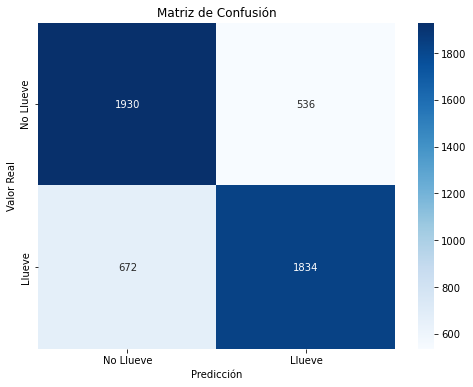

In [163]:
# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# La graficamos
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Llueve', 'Llueve'], yticklabels=['No Llueve', 'Llueve'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

## *Redes Neuronales*

### **RainfallTomorrow**

#### *Etapa 1: Buscamos el mejor modelo de RN*

In [352]:
# Dividimos los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_rainfall_float, Y_rainfall_float, test_size=0.2, random_state=42)

# Definimos la función para crear el modelo
def create_model(trial):
    model = Sequential()

    # Número de capas ocultas
    num_layers = trial.suggest_int('num_layers', 4, 25)

    # Número de neuronas por capa
    num_neurons_ent = trial.suggest_int('num_neurons_ent', 16, 500)

    # Función de activación
    activation_ent = trial.suggest_categorical('activation_ent', ['relu', 'tanh', 'elu', 'selu', 'linear'])

    # Añadimos capas ocultas según los hiperparámetros
    model.add(Dense(num_neurons_ent, input_dim=X_train.shape[1], activation=activation_ent))
    
    for i in range(num_layers - 1):
        # Número de neuronas por capa
        num_neurons_int = trial.suggest_int(f'n_neurons_layer_{i}', 16, 500)
        
        # Función de activación
        activation_int = trial.suggest_categorical(f'activation_int_{i}', ['relu', 'tanh', 'elu', 'selu', 'linear'])
        
        # Añadimos capas ocultas según los hiperparámetros
        model.add(Dense(num_neurons_int, activation=activation_int))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Definimos la función objetivo para la optimización
def objective(trial):
    model = create_model(trial)

    # Entrenamos el modelo
    model.fit(X_train, y_train, epochs=500, batch_size=32768, validation_data=(X_test, y_test), verbose=0)
    
    # Predecimos para el conjunto de test
    y_pred = model.predict(X_test)
    
    # Calculamos el Error Cuadrático Medio
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Configuramos y ejecutamos la optimización de hiperparámetros con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

# Mostramos los resultados
print('Mejor valor encontrado: ', study.best_value)
print('Mejores hiperparámetros: ', study.best_params)

[I 2023-11-20 04:25:42,979] A new study created in memory with name: no-name-f48fe911-c074-4e37-a25a-f78a987805a3
[I 2023-11-20 04:27:14,288] Trial 0 finished with value: 0.25056949257850647 and parameters: {'num_layers': 14, 'num_neurons_ent': 273, 'activation_ent': 'linear', 'n_neurons_layer_0': 408, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 437, 'activation_int_1': 'relu', 'n_neurons_layer_2': 214, 'activation_int_2': 'linear', 'n_neurons_layer_3': 416, 'activation_int_3': 'tanh', 'n_neurons_layer_4': 466, 'activation_int_4': 'relu', 'n_neurons_layer_5': 62, 'activation_int_5': 'elu', 'n_neurons_layer_6': 453, 'activation_int_6': 'relu', 'n_neurons_layer_7': 211, 'activation_int_7': 'tanh', 'n_neurons_layer_8': 356, 'activation_int_8': 'selu', 'n_neurons_layer_9': 323, 'activation_int_9': 'elu', 'n_neurons_layer_10': 304, 'activation_int_10': 'tanh', 'n_neurons_layer_11': 385, 'activation_int_11': 'relu', 'n_neurons_layer_12': 230, 'activation_int_12': 'relu'}. Best is trial 

[I 2023-11-20 04:38:46,764] Trial 9 finished with value: 0.29702028632164 and parameters: {'num_layers': 8, 'num_neurons_ent': 481, 'activation_ent': 'elu', 'n_neurons_layer_0': 372, 'activation_int_0': 'relu', 'n_neurons_layer_1': 447, 'activation_int_1': 'selu', 'n_neurons_layer_2': 17, 'activation_int_2': 'linear', 'n_neurons_layer_3': 52, 'activation_int_3': 'selu', 'n_neurons_layer_4': 288, 'activation_int_4': 'elu', 'n_neurons_layer_5': 183, 'activation_int_5': 'relu', 'n_neurons_layer_6': 22, 'activation_int_6': 'elu'}. Best is trial 0 with value: 0.25056949257850647.
[I 2023-11-20 04:38:53,937] Trial 10 finished with value: 0.4882274270057678 and parameters: {'num_layers': 2, 'num_neurons_ent': 159, 'activation_ent': 'linear', 'n_neurons_layer_0': 210, 'activation_int_0': 'tanh'}. Best is trial 0 with value: 0.25056949257850647.
[I 2023-11-20 04:39:21,276] Trial 11 finished with value: 0.4459158182144165 and parameters: {'num_layers': 3, 'num_neurons_ent': 484, 'activation_ent'

[I 2023-11-20 04:49:41,753] Trial 19 finished with value: 0.30990079045295715 and parameters: {'num_layers': 12, 'num_neurons_ent': 309, 'activation_ent': 'linear', 'n_neurons_layer_0': 311, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 186, 'activation_int_1': 'relu', 'n_neurons_layer_2': 460, 'activation_int_2': 'linear', 'n_neurons_layer_3': 334, 'activation_int_3': 'linear', 'n_neurons_layer_4': 109, 'activation_int_4': 'relu', 'n_neurons_layer_5': 420, 'activation_int_5': 'tanh', 'n_neurons_layer_6': 491, 'activation_int_6': 'elu', 'n_neurons_layer_7': 382, 'activation_int_7': 'elu', 'n_neurons_layer_8': 239, 'activation_int_8': 'elu', 'n_neurons_layer_9': 99, 'activation_int_9': 'elu', 'n_neurons_layer_10': 189, 'activation_int_10': 'tanh'}. Best is trial 14 with value: 0.23118893802165985.
[I 2023-11-20 04:50:43,065] Trial 20 finished with value: 0.47357380390167236 and parameters: {'num_layers': 21, 'num_neurons_ent': 92, 'activation_ent': 'tanh', 'n_neurons_layer_0': 242, '

[I 2023-11-20 05:04:08,817] Trial 28 finished with value: 0.3124529719352722 and parameters: {'num_layers': 19, 'num_neurons_ent': 252, 'activation_ent': 'linear', 'n_neurons_layer_0': 184, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 286, 'activation_int_1': 'relu', 'n_neurons_layer_2': 62, 'activation_int_2': 'linear', 'n_neurons_layer_3': 469, 'activation_int_3': 'tanh', 'n_neurons_layer_4': 445, 'activation_int_4': 'relu', 'n_neurons_layer_5': 320, 'activation_int_5': 'selu', 'n_neurons_layer_6': 391, 'activation_int_6': 'selu', 'n_neurons_layer_7': 66, 'activation_int_7': 'elu', 'n_neurons_layer_8': 386, 'activation_int_8': 'elu', 'n_neurons_layer_9': 239, 'activation_int_9': 'elu', 'n_neurons_layer_10': 430, 'activation_int_10': 'tanh', 'n_neurons_layer_11': 500, 'activation_int_11': 'relu', 'n_neurons_layer_12': 179, 'activation_int_12': 'selu', 'n_neurons_layer_13': 326, 'activation_int_13': 'linear', 'n_neurons_layer_14': 317, 'activation_int_14': 'selu', 'n_neurons_layer_

[I 2023-11-20 05:15:43,438] Trial 38 finished with value: 0.6926655769348145 and parameters: {'num_layers': 19, 'num_neurons_ent': 127, 'activation_ent': 'selu', 'n_neurons_layer_0': 96, 'activation_int_0': 'relu', 'n_neurons_layer_1': 119, 'activation_int_1': 'elu', 'n_neurons_layer_2': 201, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 444, 'activation_int_3': 'tanh', 'n_neurons_layer_4': 262, 'activation_int_4': 'selu', 'n_neurons_layer_5': 490, 'activation_int_5': 'selu', 'n_neurons_layer_6': 423, 'activation_int_6': 'relu', 'n_neurons_layer_7': 104, 'activation_int_7': 'elu', 'n_neurons_layer_8': 371, 'activation_int_8': 'linear', 'n_neurons_layer_9': 103, 'activation_int_9': 'tanh', 'n_neurons_layer_10': 230, 'activation_int_10': 'relu', 'n_neurons_layer_11': 466, 'activation_int_11': 'tanh', 'n_neurons_layer_12': 86, 'activation_int_12': 'elu', 'n_neurons_layer_13': 499, 'activation_int_13': 'selu', 'n_neurons_layer_14': 174, 'activation_int_14': 'tanh', 'n_neurons_layer_15':

[I 2023-11-20 05:26:16,588] Trial 46 finished with value: 0.29473406076431274 and parameters: {'num_layers': 17, 'num_neurons_ent': 362, 'activation_ent': 'linear', 'n_neurons_layer_0': 336, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 362, 'activation_int_1': 'selu', 'n_neurons_layer_2': 128, 'activation_int_2': 'linear', 'n_neurons_layer_3': 137, 'activation_int_3': 'selu', 'n_neurons_layer_4': 162, 'activation_int_4': 'selu', 'n_neurons_layer_5': 474, 'activation_int_5': 'relu', 'n_neurons_layer_6': 206, 'activation_int_6': 'elu', 'n_neurons_layer_7': 150, 'activation_int_7': 'elu', 'n_neurons_layer_8': 263, 'activation_int_8': 'relu', 'n_neurons_layer_9': 47, 'activation_int_9': 'selu', 'n_neurons_layer_10': 195, 'activation_int_10': 'linear', 'n_neurons_layer_11': 438, 'activation_int_11': 'relu', 'n_neurons_layer_12': 95, 'activation_int_12': 'selu', 'n_neurons_layer_13': 471, 'activation_int_13': 'selu', 'n_neurons_layer_14': 369, 'activation_int_14': 'elu', 'n_neurons_layer

[I 2023-11-20 05:32:55,300] Trial 62 finished with value: 0.22900518774986267 and parameters: {'num_layers': 7, 'num_neurons_ent': 167, 'activation_ent': 'relu', 'n_neurons_layer_0': 315, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 477, 'activation_int_1': 'relu', 'n_neurons_layer_2': 87, 'activation_int_2': 'linear', 'n_neurons_layer_3': 484, 'activation_int_3': 'relu', 'n_neurons_layer_4': 44, 'activation_int_4': 'linear', 'n_neurons_layer_5': 430, 'activation_int_5': 'linear'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 05:33:20,837] Trial 63 finished with value: 0.22662252187728882 and parameters: {'num_layers': 5, 'num_neurons_ent': 193, 'activation_ent': 'relu', 'n_neurons_layer_0': 335, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 428, 'activation_int_1': 'relu', 'n_neurons_layer_2': 92, 'activation_int_2': 'linear', 'n_neurons_layer_3': 433, 'activation_int_3': 'relu'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 05:33:49,971] T

[I 2023-11-20 05:43:04,085] Trial 76 finished with value: 0.2810727059841156 and parameters: {'num_layers': 7, 'num_neurons_ent': 280, 'activation_ent': 'elu', 'n_neurons_layer_0': 431, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 379, 'activation_int_1': 'relu', 'n_neurons_layer_2': 112, 'activation_int_2': 'linear', 'n_neurons_layer_3': 465, 'activation_int_3': 'relu', 'n_neurons_layer_4': 299, 'activation_int_4': 'elu', 'n_neurons_layer_5': 379, 'activation_int_5': 'linear'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 05:43:12,360] Trial 77 finished with value: 0.4483639597892761 and parameters: {'num_layers': 2, 'num_neurons_ent': 239, 'activation_ent': 'selu', 'n_neurons_layer_0': 123, 'activation_int_0': 'relu'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 05:43:31,937] Trial 78 finished with value: 0.3235238492488861 and parameters: {'num_layers': 5, 'num_neurons_ent': 302, 'activation_ent': 'tanh', 'n_neurons_layer_0': 160, 'activati

[I 2023-11-20 05:53:05,274] Trial 90 finished with value: 0.22385789453983307 and parameters: {'num_layers': 10, 'num_neurons_ent': 247, 'activation_ent': 'relu', 'n_neurons_layer_0': 293, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 414, 'activation_int_1': 'relu', 'n_neurons_layer_2': 72, 'activation_int_2': 'relu', 'n_neurons_layer_3': 388, 'activation_int_3': 'relu', 'n_neurons_layer_4': 34, 'activation_int_4': 'selu', 'n_neurons_layer_5': 457, 'activation_int_5': 'tanh', 'n_neurons_layer_6': 354, 'activation_int_6': 'selu', 'n_neurons_layer_7': 225, 'activation_int_7': 'tanh', 'n_neurons_layer_8': 69, 'activation_int_8': 'linear'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 05:53:49,923] Trial 91 finished with value: 0.24648194015026093 and parameters: {'num_layers': 10, 'num_neurons_ent': 248, 'activation_ent': 'relu', 'n_neurons_layer_0': 288, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 404, 'activation_int_1': 'relu', 'n_neurons_layer_2': 71, 'acti

[I 2023-11-20 06:05:39,782] Trial 103 finished with value: 0.2940705716609955 and parameters: {'num_layers': 18, 'num_neurons_ent': 160, 'activation_ent': 'tanh', 'n_neurons_layer_0': 218, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 350, 'activation_int_1': 'relu', 'n_neurons_layer_2': 135, 'activation_int_2': 'linear', 'n_neurons_layer_3': 500, 'activation_int_3': 'relu', 'n_neurons_layer_4': 446, 'activation_int_4': 'linear', 'n_neurons_layer_5': 460, 'activation_int_5': 'tanh', 'n_neurons_layer_6': 403, 'activation_int_6': 'relu', 'n_neurons_layer_7': 136, 'activation_int_7': 'elu', 'n_neurons_layer_8': 24, 'activation_int_8': 'linear', 'n_neurons_layer_9': 236, 'activation_int_9': 'selu', 'n_neurons_layer_10': 210, 'activation_int_10': 'tanh', 'n_neurons_layer_11': 280, 'activation_int_11': 'selu', 'n_neurons_layer_12': 278, 'activation_int_12': 'tanh', 'n_neurons_layer_13': 98, 'activation_int_13': 'tanh', 'n_neurons_layer_14': 354, 'activation_int_14': 'elu', 'n_neurons_laye

[I 2023-11-20 06:14:32,192] Trial 113 finished with value: 0.2608550786972046 and parameters: {'num_layers': 13, 'num_neurons_ent': 132, 'activation_ent': 'selu', 'n_neurons_layer_0': 95, 'activation_int_0': 'selu', 'n_neurons_layer_1': 441, 'activation_int_1': 'linear', 'n_neurons_layer_2': 68, 'activation_int_2': 'linear', 'n_neurons_layer_3': 449, 'activation_int_3': 'relu', 'n_neurons_layer_4': 190, 'activation_int_4': 'elu', 'n_neurons_layer_5': 327, 'activation_int_5': 'elu', 'n_neurons_layer_6': 294, 'activation_int_6': 'relu', 'n_neurons_layer_7': 190, 'activation_int_7': 'selu', 'n_neurons_layer_8': 291, 'activation_int_8': 'linear', 'n_neurons_layer_9': 17, 'activation_int_9': 'tanh', 'n_neurons_layer_10': 354, 'activation_int_10': 'relu', 'n_neurons_layer_11': 97, 'activation_int_11': 'selu'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 06:15:45,057] Trial 114 finished with value: 0.27010929584503174 and parameters: {'num_layers': 14, 'num_neurons_ent': 1

[I 2023-11-20 06:26:22,610] Trial 124 finished with value: 0.41326668858528137 and parameters: {'num_layers': 7, 'num_neurons_ent': 180, 'activation_ent': 'linear', 'n_neurons_layer_0': 193, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 434, 'activation_int_1': 'relu', 'n_neurons_layer_2': 93, 'activation_int_2': 'linear', 'n_neurons_layer_3': 444, 'activation_int_3': 'selu', 'n_neurons_layer_4': 474, 'activation_int_4': 'elu', 'n_neurons_layer_5': 417, 'activation_int_5': 'tanh'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 06:26:58,797] Trial 125 finished with value: 0.2703842222690582 and parameters: {'num_layers': 9, 'num_neurons_ent': 273, 'activation_ent': 'relu', 'n_neurons_layer_0': 219, 'activation_int_0': 'linear', 'n_neurons_layer_1': 473, 'activation_int_1': 'relu', 'n_neurons_layer_2': 154, 'activation_int_2': 'selu', 'n_neurons_layer_3': 461, 'activation_int_3': 'elu', 'n_neurons_layer_4': 30, 'activation_int_4': 'tanh', 'n_neurons_layer_5': 85, 'ac

[I 2023-11-20 06:37:28,490] Trial 137 finished with value: 0.3124304711818695 and parameters: {'num_layers': 3, 'num_neurons_ent': 245, 'activation_ent': 'relu', 'n_neurons_layer_0': 308, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 427, 'activation_int_1': 'relu'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 06:38:30,393] Trial 138 finished with value: 0.28694912791252136 and parameters: {'num_layers': 9, 'num_neurons_ent': 268, 'activation_ent': 'selu', 'n_neurons_layer_0': 283, 'activation_int_0': 'relu', 'n_neurons_layer_1': 463, 'activation_int_1': 'relu', 'n_neurons_layer_2': 27, 'activation_int_2': 'relu', 'n_neurons_layer_3': 457, 'activation_int_3': 'relu', 'n_neurons_layer_4': 428, 'activation_int_4': 'linear', 'n_neurons_layer_5': 477, 'activation_int_5': 'tanh', 'n_neurons_layer_6': 458, 'activation_int_6': 'linear', 'n_neurons_layer_7': 60, 'activation_int_7': 'elu'}. Best is trial 37 with value: 0.20548409223556519.
[I 2023-11-20 06:39:08,104] Tria

Mejor valor encontrado:  0.20548409223556519
Mejores hiperparámetros:  {'num_layers': 15, 'num_neurons_ent': 231, 'activation_ent': 'selu', 'n_neurons_layer_0': 158, 'activation_int_0': 'relu', 'n_neurons_layer_1': 135, 'activation_int_1': 'elu', 'n_neurons_layer_2': 204, 'activation_int_2': 'linear', 'n_neurons_layer_3': 353, 'activation_int_3': 'tanh', 'n_neurons_layer_4': 335, 'activation_int_4': 'selu', 'n_neurons_layer_5': 498, 'activation_int_5': 'selu', 'n_neurons_layer_6': 424, 'activation_int_6': 'relu', 'n_neurons_layer_7': 117, 'activation_int_7': 'elu', 'n_neurons_layer_8': 383, 'activation_int_8': 'linear', 'n_neurons_layer_9': 127, 'activation_int_9': 'tanh', 'n_neurons_layer_10': 147, 'activation_int_10': 'relu', 'n_neurons_layer_11': 346, 'activation_int_11': 'relu', 'n_neurons_layer_12': 90, 'activation_int_12': 'selu', 'n_neurons_layer_13': 480, 'activation_int_13': 'selu'}


#### *Etapa 2: Creamos el mejor modelo de RN*

In [448]:
class PrintProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            print(f'Epoch {epoch}. Train MSE: {logs["loss"]:.5f}, Train MAE: {logs["mae"]:.5f}. Test MSE: {logs["val_loss"]:.5f} Test MAE: {logs["val_mae"]:.5f}.')

class NeuralNetworkTensorFlow(BaseEstimator, RegressorMixin):
    def __init__(self, lr=1, epochs=1000, batch_size=32768, verbose=2):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = self.build_model()

    def build_model(self):
        best_params_nn = study.best_params
        sublist = []
        layers = []
        regularizer = 0

        for key, value in best_params_nn.items():
            if key != 'num_layers': sublist.append([key, value])

            if len(sublist) == 2:
                layers.append(sublist)
                sublist = []
                
        model = Sequential()    
        for neurons, activation in layers:
            regularizer += 1
            layer_name = neurons[0]
            num_neurons = neurons[1]
            activation_name = activation[1]

            if layer_name == 'num_neurons_ent': 
                model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation=activation_name))
            else:
                model.add(Dense(num_neurons, activation=activation_name))
                
            if len(layers) % 2 == 0 and regularizer == 4: 
                model.add(Dropout(0.1))
                regularizer = 0
            elif len(layers) % 2 == 1 and regularizer == 3:
                model.add(Dropout(0.1))
                regularizer = 0
        
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        return model

    def fit(self, X, y, X_test=None, y_test=None):
        X = np.array(X)
        y = np.array(y)

        print(f'LR: {self.lr}, Total Epochs: {self.epochs}\n')
        callbacks = [PrintProgressCallback()] if self.verbose == 2 else []
        self.model.fit(X, y, epochs=self.epochs, verbose=0, callbacks=callbacks, batch_size=self.batch_size, validation_data=(X_test, y_test))
        return self

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

#### *Etapa 3: Buscamos el mejor LR de la RN*

In [452]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X_rainfall_float, Y_rainfall_float, test_size=0.2, random_state=0)

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento y validación
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, random_state=0)

# Creamos una instancia de la Red Neuronal
nn_tensorflow = NeuralNetworkTensorFlow()

# Definimos los parámetros a optimizar
param_grid = {
    'lr': [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

# Configuramos la búsqueda de hiperparámetros
grid_search = GridSearchCV(nn_tensorflow, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Realizamos la búsqueda de hiperparámetros
grid_search.fit(X_train, Y_train, X_test=X_test, y_test=Y_test)

# Limpiamos la consola
limpiar_consola()

# Mostramos los mejores hiperparámetros
print('\nMejores hiperparámetros encontrados:', grid_search.best_params_)

# Obtenemos la predicción en el conjunto de validación
Y_pred = grid_search.best_estimator_.predict(X_val)

# Calculamos el Error Absoluto Medio en el conjunto de validación
mae = mean_absolute_error(Y_val, Y_pred)
print('Error Absoluto Medio en el conjunto de validación:', mae)

LR: 1e-05, Total Epochs: 1000

Epoch 0. Train MSE: 1.01250, Train MAE: 0.98446. Test MSE: 1.05107 Test MAE: 0.84913.
Epoch 100. Train MSE: 0.41311, Train MAE: 0.46417. Test MSE: 0.50752 Test MAE: 0.54125.
Epoch 200. Train MSE: 0.26395, Train MAE: 0.31228. Test MSE: 0.44215 Test MAE: 0.42982.
Epoch 300. Train MSE: 0.12417, Train MAE: 0.19940. Test MSE: 0.37171 Test MAE: 0.35790.
Epoch 400. Train MSE: 0.07631, Train MAE: 0.15536. Test MSE: 0.37922 Test MAE: 0.33328.
Epoch 500. Train MSE: 0.05655, Train MAE: 0.13427. Test MSE: 0.36599 Test MAE: 0.31576.
Epoch 600. Train MSE: 0.03974, Train MAE: 0.11271. Test MSE: 0.37460 Test MAE: 0.30586.
Epoch 700. Train MSE: 0.03453, Train MAE: 0.09993. Test MSE: 0.38100 Test MAE: 0.29010.
Epoch 800. Train MSE: 0.02936, Train MAE: 0.08981. Test MSE: 0.36288 Test MAE: 0.28238.
Epoch 900. Train MSE: 0.02634, Train MAE: 0.08563. Test MSE: 0.39957 Test MAE: 0.29038.
LR: 1e-05, Total Epochs: 1000

Epoch 0. Train MSE: 1.07741, Train MAE: 0.97637. Test MSE: 2

Epoch 0. Train MSE: 1.07899, Train MAE: 1.00770. Test MSE: 1.30483 Test MAE: 0.91553.
Epoch 100. Train MSE: 0.41578, Train MAE: 0.45455. Test MSE: 0.50911 Test MAE: 0.52198.
Epoch 200. Train MSE: 0.22612, Train MAE: 0.29256. Test MSE: 0.42055 Test MAE: 0.42038.
Epoch 300. Train MSE: 0.13325, Train MAE: 0.21323. Test MSE: 0.38248 Test MAE: 0.37476.
Epoch 400. Train MSE: 0.08579, Train MAE: 0.16621. Test MSE: 0.38253 Test MAE: 0.35232.
Epoch 500. Train MSE: 0.06175, Train MAE: 0.13616. Test MSE: 0.35059 Test MAE: 0.30408.
Epoch 600. Train MSE: 0.04411, Train MAE: 0.11255. Test MSE: 0.36331 Test MAE: 0.30702.
Epoch 700. Train MSE: 0.03763, Train MAE: 0.10330. Test MSE: 0.37300 Test MAE: 0.29898.
Epoch 800. Train MSE: 0.03176, Train MAE: 0.09395. Test MSE: 0.35685 Test MAE: 0.28079.
Epoch 900. Train MSE: 0.03379, Train MAE: 0.09823. Test MSE: 0.36658 Test MAE: 0.28185.
LR: 0.001, Total Epochs: 1000

Epoch 0. Train MSE: 1.03688, Train MAE: 0.99626. Test MSE: 0.88411 Test MAE: 0.86268.
Epoch

Epoch 100. Train MSE: 0.40580, Train MAE: 0.45913. Test MSE: 0.49437 Test MAE: 0.50265.
Epoch 200. Train MSE: 0.23546, Train MAE: 0.31746. Test MSE: 0.44504 Test MAE: 0.42739.
Epoch 300. Train MSE: 0.12042, Train MAE: 0.19966. Test MSE: 0.40013 Test MAE: 0.36967.
Epoch 400. Train MSE: 0.08003, Train MAE: 0.15433. Test MSE: 0.42795 Test MAE: 0.36398.
Epoch 500. Train MSE: 0.06663, Train MAE: 0.14008. Test MSE: 0.37725 Test MAE: 0.31861.
Epoch 600. Train MSE: 0.04099, Train MAE: 0.11235. Test MSE: 0.38918 Test MAE: 0.30997.
Epoch 700. Train MSE: 0.03400, Train MAE: 0.10561. Test MSE: 0.37375 Test MAE: 0.30623.
Epoch 800. Train MSE: 0.02690, Train MAE: 0.08855. Test MSE: 0.38087 Test MAE: 0.30609.
Epoch 900. Train MSE: 0.02340, Train MAE: 0.08199. Test MSE: 0.37586 Test MAE: 0.29134.
LR: 0.01, Total Epochs: 1000

Epoch 0. Train MSE: 1.00306, Train MAE: 0.98186. Test MSE: 1.00658 Test MAE: 0.80261.
Epoch 100. Train MSE: 0.43000, Train MAE: 0.46284. Test MSE: 0.51358 Test MAE: 0.53726.
Epoc

#### *Etapa 4: Probamos la Red Neuronal*

In [462]:
# Lista para guardar los scores
scores = []

# Creamos una instancia de KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Separamos en conjuntos de entrenamiento y prueba según los índices del KFold
# en todos los datos
for train_index, test_index in kf.split(X_rainfall_float):
    X_train, X_test = X_rainfall_float.iloc[train_index], X_rainfall_float.iloc[test_index]
    y_train, y_test = Y_rainfall_float.iloc[train_index], Y_rainfall_float.iloc[test_index]

    # Creamos un conjunto de validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Creamos una instancia de la Red Neuronal
    nn_tensorflow = NeuralNetworkTensorFlow(lr=grid_search.best_estimator_.get_params()['lr'])

    # Entrenamos el modelo
    nn_tensorflow.fit(X_train, y_train, X_test=X_test, y_test=y_test)

    # Obtenemos la predicción en el conjunto de prueba
    y_pred = nn_tensorflow.predict(X_val)

    # Guardamos las predicciones y los valores reales
    score = [y_val, y_pred]
    scores.append(score)
    
# Aviso
print('Se terminó el entrenamiento.')

LR: 0.1, Total Epochs: 1000

Epoch 0. Train MSE: 1.05569, Train MAE: 0.97284. Test MSE: 2.65147 Test MAE: 1.35142.
Epoch 100. Train MSE: 0.43414, Train MAE: 0.46743. Test MSE: 0.49565 Test MAE: 0.51929.
Epoch 200. Train MSE: 0.27467, Train MAE: 0.35084. Test MSE: 0.44159 Test MAE: 0.44823.
Epoch 300. Train MSE: 0.17835, Train MAE: 0.26046. Test MSE: 0.38515 Test MAE: 0.37906.
Epoch 400. Train MSE: 0.10158, Train MAE: 0.18080. Test MSE: 0.33385 Test MAE: 0.32682.
Epoch 500. Train MSE: 0.07345, Train MAE: 0.15464. Test MSE: 0.31870 Test MAE: 0.29147.
Epoch 600. Train MSE: 0.05689, Train MAE: 0.12638. Test MSE: 0.30674 Test MAE: 0.25556.
Epoch 700. Train MSE: 0.04023, Train MAE: 0.10448. Test MSE: 0.31268 Test MAE: 0.26030.
Epoch 800. Train MSE: 0.03431, Train MAE: 0.09552. Test MSE: 0.32282 Test MAE: 0.25379.
Epoch 900. Train MSE: 0.02795, Train MAE: 0.08746. Test MSE: 0.30251 Test MAE: 0.23745.
LR: 0.1, Total Epochs: 1000

Epoch 0. Train MSE: 1.06119, Train MAE: 0.98987. Test MSE: 1.843

Epoch 100. Train MSE: 0.39068, Train MAE: 0.43733. Test MSE: 0.46984 Test MAE: 0.49755.
Epoch 200. Train MSE: 0.19468, Train MAE: 0.27071. Test MSE: 0.33479 Test MAE: 0.34724.
Epoch 300. Train MSE: 0.11082, Train MAE: 0.19113. Test MSE: 0.29558 Test MAE: 0.31194.
Epoch 400. Train MSE: 0.07251, Train MAE: 0.15164. Test MSE: 0.31300 Test MAE: 0.29938.
Epoch 500. Train MSE: 0.05208, Train MAE: 0.12744. Test MSE: 0.27202 Test MAE: 0.25994.
Epoch 600. Train MSE: 0.04998, Train MAE: 0.11749. Test MSE: 0.27664 Test MAE: 0.24987.
Epoch 700. Train MSE: 0.03345, Train MAE: 0.09606. Test MSE: 0.26397 Test MAE: 0.23992.
Epoch 800. Train MSE: 0.02918, Train MAE: 0.08887. Test MSE: 0.27455 Test MAE: 0.22630.
Epoch 900. Train MSE: 0.02494, Train MAE: 0.08391. Test MSE: 0.25590 Test MAE: 0.21403.
Se terminó el entrenamiento.


#### *Etapa 5: Mostramos los resultados*

In [464]:
# Definimos las columnas de la tabla
columns = ['Split', 'R2', 'MAE', 'MSE', 'RMSE']

# Creamos una instancia de PrettyTable
table = PrettyTable(columns)

# Listas para almacenar las métricas de cada división
r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []

# Recorremos las listas de scores
for i, sublist in enumerate(scores):
    predictions = sublist[0]  # Guardamos las predicciones
    real_values = sublist[1]  # Guardamos los valores reales

    # Calculamos las métricas
    r2 = r2_score(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    mse = mean_squared_error(real_values, predictions)
    rmse = np.sqrt(mse)

    # Almacenamos las métricas en las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

    # Añadimos la fila a la tabla
    table.add_row([f'Split {i + 1}', f'{r2:.5f}', f'{mae:.5f}', f'{mse:.5f}', f'{rmse:.5f}'])

# Calculamos los promedios
r2_mean = np.mean(r2_scores)
mae_mean = np.mean(mae_scores)
mse_mean = np.mean(mse_scores)
rmse_mean = np.mean(rmse_scores)

# Añadimos la fila de promedios a la tabla
table.add_row(['Promedio', f'{r2_mean:.5f}', f'{mae_mean:.5f}', f'{mse_mean:.5f}', f'{rmse_mean:.5f}'])

# Mostramos la tabla
print(table)

+----------+---------+---------+---------+---------+
|  Split   |    R2   |   MAE   |   MSE   |   RMSE  |
+----------+---------+---------+---------+---------+
| Split 1  | 0.69418 | 0.22640 | 0.28330 | 0.53226 |
| Split 2  | 0.68451 | 0.23185 | 0.28804 | 0.53670 |
| Split 3  | 0.67601 | 0.23186 | 0.30183 | 0.54939 |
| Split 4  | 0.66240 | 0.23733 | 0.31382 | 0.56019 |
| Split 5  | 0.69397 | 0.22096 | 0.28506 | 0.53391 |
| Split 6  | 0.68519 | 0.22802 | 0.29037 | 0.53886 |
| Split 7  | 0.66692 | 0.24050 | 0.30682 | 0.55391 |
| Split 8  | 0.64697 | 0.24713 | 0.32266 | 0.56803 |
| Split 9  | 0.66218 | 0.24095 | 0.30586 | 0.55305 |
| Split 10 | 0.68926 | 0.22381 | 0.28923 | 0.53780 |
| Promedio | 0.67616 | 0.23288 | 0.29870 | 0.54641 |
+----------+---------+---------+---------+---------+


#### *Etapa 6: Aumento de datos con Data Augmentation*

In [465]:
def data_augmentation_continuous(X, y, noise_std=0.1, jitter_factor=0.1, scale_factor=1.1, shift_offset=0.1):
    """
    Aplica aumentos de datos a un conjunto de datos continuos.

    Parámetros:
    - X: Array numpy con las características.
    - y: Array numpy con las etiquetas.
    - noise_std: Desviación estándar del ruido gaussiano a agregar.
    - jitter_factor: Factor de jittering para agregar perturbaciones aleatorias.
    - scale_factor: Factor de escala para aplicar transformación lineal de escala.
    - shift_offset: Valor de desplazamiento para aplicar transformación lineal de traslación.

    Retorna:
    - X_augmented: Conjunto de datos aumentado.
    - y_augmented: Etiquetas aumentadas.
    """
    # Añadimos ruido
    X_noisy = X + np.random.normal(0, noise_std, size=X.shape)

    # Jittering
    X_jittered = X_noisy + np.random.uniform(-jitter_factor, jitter_factor, size=X.shape)

    # Transformación lineal de escala
    X_scaled = X_jittered * scale_factor

    # Transformación lineal de traslación
    X_shifted = X_scaled + shift_offset

    # Concatenamos datos originales con datos aumentados
    X_augmented = np.vstack([X, X_noisy, X_jittered, X_scaled, X_shifted])
    y_augmented = np.concatenate([y] * 5)  # Repetimos las etiquetas para los datos aumentados

    return X_augmented, y_augmented

# Aumentamos nuestros datos
X_rainfall_aug, Y_rainfall_aug = data_augmentation_continuous(X_rainfall, Y_rainfall)

# Identificamos las filas correspondientes a los datos originales
num_original_samples = X_rainfall.shape[0]

# Eliminamos los datos originales de los aumentados
X_augmented_without_original = X_rainfall_aug[num_original_samples:, :]
Y_augmented_without_original = Y_rainfall_aug[num_original_samples:]

# Vemos su tamaño después del aumento sin los originales
print(f'Datos reales: X: {X_rainfall.shape}. Y: {Y_rainfall.shape}\nDatos aumentados sin originales: X: {X_augmented_without_original.shape}. Y: {Y_augmented_without_original.shape}')

Datos reales: X: (24860, 21). Y: (24860,)
Datos aumentados sin originales: X: (99440, 21). Y: (99440,)


#### *Etapa 7: Prueba con el mejor modelo, hiperparámetros y mayor cantidad de datos*

In [466]:
from sklearn.model_selection import KFold

# Lista para guardar los scores
scores_aug = []

# Creamos una instancia de KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Separamos en conjuntos de entrenamiento y prueba según los índices del KFold
# en los datos aumentados sin los originales
for train_index, test_index in kf.split(X_augmented_without_original):
    X_train, X_test = X_augmented_without_original[train_index], X_augmented_without_original[test_index]
    y_train, y_test = Y_augmented_without_original[train_index], Y_augmented_without_original[test_index]
    
    # Creamos una instancia de la Red Neuronal
    nn_tensorflow = NeuralNetworkTensorFlow(lr=grid_search.best_estimator_.get_params()['lr'])

    # Entrenamos el modelo
    nn_tensorflow.fit(X_train, y_train, X_test=X_test, y_test=y_test)

    # Obtenemos la predicción en el conjunto original de los datos
    y_pred = nn_tensorflow.predict(X_rainfall_float)

    # Guardamos las predicciones y los valores reales
    score = [Y_rainfall_float, y_pred]
    scores_aug.append(score)
    
# Aviso
print('Se terminó el entrenamiento.')

LR: 0.1, Total Epochs: 1000

Epoch 0. Train MSE: 1.45335, Train MAE: 1.05838. Test MSE: 0.77271 Test MAE: 0.83523.
Epoch 100. Train MSE: 0.18979, Train MAE: 0.26132. Test MSE: 0.16558 Test MAE: 0.26506.
Epoch 200. Train MSE: 0.07129, Train MAE: 0.14483. Test MSE: 0.05408 Test MAE: 0.13234.
Epoch 300. Train MSE: 0.04350, Train MAE: 0.10709. Test MSE: 0.03064 Test MAE: 0.08643.
Epoch 400. Train MSE: 0.03019, Train MAE: 0.08808. Test MSE: 0.02152 Test MAE: 0.06975.
Epoch 500. Train MSE: 0.02473, Train MAE: 0.07738. Test MSE: 0.01744 Test MAE: 0.05968.
Epoch 600. Train MSE: 0.02421, Train MAE: 0.07572. Test MSE: 0.01616 Test MAE: 0.05724.
Epoch 700. Train MSE: 0.01745, Train MAE: 0.06709. Test MSE: 0.01139 Test MAE: 0.04347.
Epoch 800. Train MSE: 0.01672, Train MAE: 0.06211. Test MSE: 0.00993 Test MAE: 0.04208.
Epoch 900. Train MSE: 0.01437, Train MAE: 0.05854. Test MSE: 0.00834 Test MAE: 0.03710.
LR: 0.1, Total Epochs: 1000

Epoch 0. Train MSE: 1.70311, Train MAE: 1.10748. Test MSE: 0.921

Epoch 100. Train MSE: 0.21162, Train MAE: 0.27617. Test MSE: 0.19021 Test MAE: 0.29499.
Epoch 200. Train MSE: 0.07932, Train MAE: 0.15039. Test MSE: 0.05866 Test MAE: 0.13808.
Epoch 300. Train MSE: 0.04592, Train MAE: 0.11168. Test MSE: 0.03428 Test MAE: 0.09173.
Epoch 400. Train MSE: 0.03249, Train MAE: 0.09033. Test MSE: 0.02302 Test MAE: 0.07370.
Epoch 500. Train MSE: 0.02721, Train MAE: 0.08154. Test MSE: 0.01709 Test MAE: 0.05680.
Epoch 600. Train MSE: 0.02036, Train MAE: 0.07060. Test MSE: 0.01367 Test MAE: 0.05470.
Epoch 700. Train MSE: 0.01844, Train MAE: 0.06712. Test MSE: 0.01152 Test MAE: 0.04843.
Epoch 800. Train MSE: 0.01659, Train MAE: 0.06411. Test MSE: 0.01021 Test MAE: 0.04255.
Epoch 900. Train MSE: 0.01500, Train MAE: 0.05931. Test MSE: 0.00766 Test MAE: 0.03855.
Se terminó el entrenamiento.


#### *Etapa 8: Mostrar resultados del modelo*

In [467]:
# Definimos las columnas de la tabla
columns = ['Split', 'R2', 'MAE', 'MSE', 'RMSE']

# Creamos una instancia de PrettyTable
table = PrettyTable(columns)

# Listas para almacenar las métricas de cada división
r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []

# Recorremos las listas de scores
for i, sublist in enumerate(scores_aug):
    predictions = sublist[0]  # Guardamos las predicciones
    real_values = sublist[1]  # Guardamos los valores reales

    # Calculamos las métricas
    r2 = r2_score(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    mse = mean_squared_error(real_values, predictions)
    rmse = np.sqrt(mse)

    # Almacenamos las métricas en las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

    # Añadimos la fila a la tabla
    table.add_row([f'Split {i + 1}', f'{r2:.5f}', f'{mae:.5f}', f'{mse:.5f}', f'{rmse:.5f}'])

# Calculamos los promedios
r2_mean = np.mean(r2_scores)
mae_mean = np.mean(mae_scores)
mse_mean = np.mean(mse_scores)
rmse_mean = np.mean(rmse_scores)

# Añadimos la fila de promedios a la tabla
table.add_row(['Promedio', f'{r2_mean:.5f}', f'{mae_mean:.5f}', f'{mse_mean:.5f}', f'{rmse_mean:.5f}'])

# Mostramos la tabla
print(table)

+----------+---------+---------+---------+---------+
|  Split   |    R2   |   MAE   |   MSE   |   RMSE  |
+----------+---------+---------+---------+---------+
| Split 1  | 0.98515 | 0.04061 | 0.01487 | 0.12193 |
| Split 2  | 0.97849 | 0.05212 | 0.02093 | 0.14468 |
| Split 3  | 0.98188 | 0.04703 | 0.01799 | 0.13411 |
| Split 4  | 0.98550 | 0.04375 | 0.01436 | 0.11982 |
| Split 5  | 0.98421 | 0.04009 | 0.01603 | 0.12662 |
| Split 6  | 0.98770 | 0.04077 | 0.01259 | 0.11221 |
| Split 7  | 0.98481 | 0.04631 | 0.01480 | 0.12165 |
| Split 8  | 0.98148 | 0.04342 | 0.01843 | 0.13577 |
| Split 9  | 0.98299 | 0.05036 | 0.01669 | 0.12919 |
| Split 10 | 0.98293 | 0.05815 | 0.01748 | 0.13220 |
| Promedio | 0.98351 | 0.04626 | 0.01642 | 0.12782 |
+----------+---------+---------+---------+---------+


### **RainTomorrow**

#### *Etapa 1: Buscamos el mejor modelo de RN*

In [468]:
# Dividimos los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_rain_float, Y_rain_float, test_size=0.2, random_state=42)

# Definimos la función para crear el modelo
def create_model(trial):
    model = Sequential()

    # Número de capas ocultas
    num_layers = trial.suggest_int('num_layers', 4, 25)

    # Número de neuronas por capa
    num_neurons_ent = trial.suggest_int('num_neurons_ent', 16, 500)

    # Función de activación
    activation_ent = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu', 'selu', 'sigmoid'])

    # Añadimos capas ocultas según los hiperparámetros
    model.add(Dense(num_neurons_ent, input_dim=X_train.shape[1], activation=activation_ent))
    
    for i in range(num_layers - 1):
        # Número de neuronas por capa
        num_neurons_int = trial.suggest_int(f'n_neurons_layer_{i}', 16, 500)
        
        # Función de activación
        activation_int = trial.suggest_categorical(f'activation_int_{i}', ['relu', 'tanh', 'elu', 'selu', 'sigmoid'])
        
        # Añadimos capas ocultas según los hiperparámetros
        model.add(Dense(num_neurons_int, activation=activation_int))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Definimos la función objetivo para la optimización
def objective(trial):
    model = create_model(trial)

    # Entrenamos el modelo
    model.fit(X_train, y_train, epochs=500, batch_size=32768, validation_data=(X_test, y_test), verbose=0)
    
    # Predecimos para el conjunto de test
    y_pred = model.predict(X_test)
    
    # Calculamos el Error Cuadrático Medio
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Configuramos y ejecutamos la optimización de hiperparámetros con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

# Mostramos los resultados
print('Mejor valor encontrado: ', study.best_value)
print('Mejores hiperparámetros: ', study.best_params)

[I 2023-11-20 11:17:03,276] A new study created in memory with name: no-name-fd121051-3b8c-4356-a0aa-91f02053f62f
[I 2023-11-20 11:19:09,163] Trial 0 finished with value: 0.25005707144737244 and parameters: {'num_layers': 24, 'num_neurons_ent': 358, 'activation': 'tanh', 'n_neurons_layer_0': 497, 'activation_int_0': 'relu', 'n_neurons_layer_1': 462, 'activation_int_1': 'relu', 'n_neurons_layer_2': 101, 'activation_int_2': 'sigmoid', 'n_neurons_layer_3': 418, 'activation_int_3': 'sigmoid', 'n_neurons_layer_4': 118, 'activation_int_4': 'sigmoid', 'n_neurons_layer_5': 110, 'activation_int_5': 'relu', 'n_neurons_layer_6': 37, 'activation_int_6': 'tanh', 'n_neurons_layer_7': 290, 'activation_int_7': 'relu', 'n_neurons_layer_8': 62, 'activation_int_8': 'selu', 'n_neurons_layer_9': 23, 'activation_int_9': 'relu', 'n_neurons_layer_10': 416, 'activation_int_10': 'relu', 'n_neurons_layer_11': 20, 'activation_int_11': 'elu', 'n_neurons_layer_12': 285, 'activation_int_12': 'selu', 'n_neurons_layer

[I 2023-11-20 11:27:22,465] Trial 8 finished with value: 0.14163705706596375 and parameters: {'num_layers': 9, 'num_neurons_ent': 297, 'activation': 'sigmoid', 'n_neurons_layer_0': 32, 'activation_int_0': 'elu', 'n_neurons_layer_1': 118, 'activation_int_1': 'sigmoid', 'n_neurons_layer_2': 180, 'activation_int_2': 'relu', 'n_neurons_layer_3': 427, 'activation_int_3': 'relu', 'n_neurons_layer_4': 232, 'activation_int_4': 'elu', 'n_neurons_layer_5': 208, 'activation_int_5': 'elu', 'n_neurons_layer_6': 273, 'activation_int_6': 'relu', 'n_neurons_layer_7': 289, 'activation_int_7': 'tanh'}. Best is trial 7 with value: 0.06515394896268845.
[I 2023-11-20 11:28:59,257] Trial 9 finished with value: 0.17547595500946045 and parameters: {'num_layers': 20, 'num_neurons_ent': 267, 'activation': 'sigmoid', 'n_neurons_layer_0': 444, 'activation_int_0': 'elu', 'n_neurons_layer_1': 240, 'activation_int_1': 'selu', 'n_neurons_layer_2': 195, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 242, 'activation

[I 2023-11-20 11:37:49,709] Trial 20 finished with value: 0.10188356041908264 and parameters: {'num_layers': 5, 'num_neurons_ent': 224, 'activation': 'selu', 'n_neurons_layer_0': 437, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 80, 'activation_int_1': 'selu', 'n_neurons_layer_2': 262, 'activation_int_2': 'sigmoid', 'n_neurons_layer_3': 186, 'activation_int_3': 'tanh'}. Best is trial 13 with value: 0.06069396436214447.
[I 2023-11-20 11:38:48,632] Trial 21 finished with value: 0.07201873511075974 and parameters: {'num_layers': 12, 'num_neurons_ent': 93, 'activation': 'tanh', 'n_neurons_layer_0': 278, 'activation_int_0': 'selu', 'n_neurons_layer_1': 364, 'activation_int_1': 'tanh', 'n_neurons_layer_2': 313, 'activation_int_2': 'relu', 'n_neurons_layer_3': 118, 'activation_int_3': 'tanh', 'n_neurons_layer_4': 343, 'activation_int_4': 'tanh', 'n_neurons_layer_5': 329, 'activation_int_5': 'selu', 'n_neurons_layer_6': 334, 'activation_int_6': 'tanh', 'n_neurons_layer_7': 387, 'activation

[I 2023-11-20 11:48:54,442] Trial 34 finished with value: 0.1488410234451294 and parameters: {'num_layers': 5, 'num_neurons_ent': 206, 'activation': 'tanh', 'n_neurons_layer_0': 321, 'activation_int_0': 'sigmoid', 'n_neurons_layer_1': 275, 'activation_int_1': 'tanh', 'n_neurons_layer_2': 461, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 409, 'activation_int_3': 'sigmoid'}. Best is trial 13 with value: 0.06069396436214447.
[I 2023-11-20 11:49:51,679] Trial 35 finished with value: 0.1260284185409546 and parameters: {'num_layers': 10, 'num_neurons_ent': 132, 'activation': 'tanh', 'n_neurons_layer_0': 288, 'activation_int_0': 'elu', 'n_neurons_layer_1': 244, 'activation_int_1': 'selu', 'n_neurons_layer_2': 286, 'activation_int_2': 'relu', 'n_neurons_layer_3': 451, 'activation_int_3': 'tanh', 'n_neurons_layer_4': 292, 'activation_int_4': 'relu', 'n_neurons_layer_5': 223, 'activation_int_5': 'selu', 'n_neurons_layer_6': 450, 'activation_int_6': 'relu', 'n_neurons_layer_7': 236, 'activati

[I 2023-11-20 11:59:52,742] Trial 47 finished with value: 0.10305153578519821 and parameters: {'num_layers': 9, 'num_neurons_ent': 36, 'activation': 'sigmoid', 'n_neurons_layer_0': 465, 'activation_int_0': 'relu', 'n_neurons_layer_1': 126, 'activation_int_1': 'relu', 'n_neurons_layer_2': 445, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 142, 'activation_int_3': 'relu', 'n_neurons_layer_4': 303, 'activation_int_4': 'relu', 'n_neurons_layer_5': 297, 'activation_int_5': 'selu', 'n_neurons_layer_6': 409, 'activation_int_6': 'relu', 'n_neurons_layer_7': 210, 'activation_int_7': 'relu'}. Best is trial 13 with value: 0.06069396436214447.
[I 2023-11-20 12:00:50,162] Trial 48 finished with value: 0.08842477947473526 and parameters: {'num_layers': 11, 'num_neurons_ent': 272, 'activation': 'tanh', 'n_neurons_layer_0': 437, 'activation_int_0': 'relu', 'n_neurons_layer_1': 197, 'activation_int_1': 'elu', 'n_neurons_layer_2': 479, 'activation_int_2': 'selu', 'n_neurons_layer_3': 21, 'activation_

[I 2023-11-20 12:10:18,506] Trial 58 finished with value: 0.059212327003479004 and parameters: {'num_layers': 6, 'num_neurons_ent': 108, 'activation': 'tanh', 'n_neurons_layer_0': 423, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 171, 'activation_int_1': 'elu', 'n_neurons_layer_2': 468, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 490, 'activation_int_3': 'relu', 'n_neurons_layer_4': 330, 'activation_int_4': 'elu'}. Best is trial 49 with value: 0.05892012640833855.
[I 2023-11-20 12:10:33,906] Trial 59 finished with value: 0.12717492878437042 and parameters: {'num_layers': 4, 'num_neurons_ent': 110, 'activation': 'tanh', 'n_neurons_layer_0': 398, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 107, 'activation_int_1': 'elu', 'n_neurons_layer_2': 461, 'activation_int_2': 'tanh'}. Best is trial 49 with value: 0.05892012640833855.
[I 2023-11-20 12:11:22,704] Trial 60 finished with value: 0.05933503434062004 and parameters: {'num_layers': 6, 'num_neurons_ent': 207, 'activation': 'e

[I 2023-11-20 12:21:14,811] Trial 75 finished with value: 0.11007218062877655 and parameters: {'num_layers': 4, 'num_neurons_ent': 168, 'activation': 'elu', 'n_neurons_layer_0': 472, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 49, 'activation_int_1': 'elu', 'n_neurons_layer_2': 484, 'activation_int_2': 'tanh'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:21:48,578] Trial 76 finished with value: 0.06440820544958115 and parameters: {'num_layers': 6, 'num_neurons_ent': 237, 'activation': 'elu', 'n_neurons_layer_0': 441, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 110, 'activation_int_1': 'elu', 'n_neurons_layer_2': 152, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 461, 'activation_int_3': 'relu', 'n_neurons_layer_4': 451, 'activation_int_4': 'elu'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:22:19,425] Trial 77 finished with value: 0.05919192358851433 and parameters: {'num_layers': 5, 'num_neurons_ent': 215, 'activation': 'elu',

[I 2023-11-20 12:32:41,423] Trial 92 finished with value: 0.10301932692527771 and parameters: {'num_layers': 4, 'num_neurons_ent': 154, 'activation': 'selu', 'n_neurons_layer_0': 434, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 163, 'activation_int_1': 'elu', 'n_neurons_layer_2': 477, 'activation_int_2': 'tanh'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:33:16,719] Trial 93 finished with value: 0.06020104140043259 and parameters: {'num_layers': 5, 'num_neurons_ent': 200, 'activation': 'selu', 'n_neurons_layer_0': 412, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 179, 'activation_int_1': 'elu', 'n_neurons_layer_2': 471, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 422, 'activation_int_3': 'relu'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:34:16,716] Trial 94 finished with value: 0.060899704694747925 and parameters: {'num_layers': 6, 'num_neurons_ent': 495, 'activation': 'selu', 'n_neurons_layer_0': 500, 'activation_int_0': '

[I 2023-11-20 12:44:39,406] Trial 109 finished with value: 0.10873640328645706 and parameters: {'num_layers': 4, 'num_neurons_ent': 82, 'activation': 'selu', 'n_neurons_layer_0': 405, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 180, 'activation_int_1': 'elu', 'n_neurons_layer_2': 488, 'activation_int_2': 'tanh'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:46:25,560] Trial 110 finished with value: 0.19655917584896088 and parameters: {'num_layers': 22, 'num_neurons_ent': 127, 'activation': 'selu', 'n_neurons_layer_0': 421, 'activation_int_0': 'elu', 'n_neurons_layer_1': 197, 'activation_int_1': 'elu', 'n_neurons_layer_2': 464, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 455, 'activation_int_3': 'relu', 'n_neurons_layer_4': 347, 'activation_int_4': 'elu', 'n_neurons_layer_5': 192, 'activation_int_5': 'tanh', 'n_neurons_layer_6': 500, 'activation_int_6': 'elu', 'n_neurons_layer_7': 268, 'activation_int_7': 'elu', 'n_neurons_layer_8': 106, 'activation_int_8

[I 2023-11-20 12:55:16,814] Trial 124 finished with value: 0.05667853355407715 and parameters: {'num_layers': 5, 'num_neurons_ent': 144, 'activation': 'selu', 'n_neurons_layer_0': 456, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 204, 'activation_int_1': 'elu', 'n_neurons_layer_2': 469, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 478, 'activation_int_3': 'relu'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:55:55,995] Trial 125 finished with value: 0.06025141105055809 and parameters: {'num_layers': 5, 'num_neurons_ent': 146, 'activation': 'selu', 'n_neurons_layer_0': 457, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 204, 'activation_int_1': 'elu', 'n_neurons_layer_2': 475, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 481, 'activation_int_3': 'relu'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 12:56:31,166] Trial 126 finished with value: 0.07682507485151291 and parameters: {'num_layers': 5, 'num_neurons_ent': 171, 'activation':

[I 2023-11-20 13:06:58,550] Trial 140 finished with value: 0.08405283093452454 and parameters: {'num_layers': 4, 'num_neurons_ent': 230, 'activation': 'selu', 'n_neurons_layer_0': 441, 'activation_int_0': 'elu', 'n_neurons_layer_1': 216, 'activation_int_1': 'elu', 'n_neurons_layer_2': 467, 'activation_int_2': 'tanh'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 13:07:46,059] Trial 141 finished with value: 0.05898253619670868 and parameters: {'num_layers': 6, 'num_neurons_ent': 114, 'activation': 'selu', 'n_neurons_layer_0': 329, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 180, 'activation_int_1': 'elu', 'n_neurons_layer_2': 479, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 491, 'activation_int_3': 'relu', 'n_neurons_layer_4': 409, 'activation_int_4': 'selu'}. Best is trial 62 with value: 0.05508833006024361.
[I 2023-11-20 13:08:33,628] Trial 142 finished with value: 0.05661587789654732 and parameters: {'num_layers': 6, 'num_neurons_ent': 118, 'activation': 

Mejor valor encontrado:  0.05508833006024361
Mejores hiperparámetros:  {'num_layers': 6, 'num_neurons_ent': 197, 'activation': 'elu', 'n_neurons_layer_0': 429, 'activation_int_0': 'tanh', 'n_neurons_layer_1': 172, 'activation_int_1': 'elu', 'n_neurons_layer_2': 487, 'activation_int_2': 'tanh', 'n_neurons_layer_3': 500, 'activation_int_3': 'relu', 'n_neurons_layer_4': 369, 'activation_int_4': 'elu'}


#### *Etapa 2: Creamos el mejor modelo de RN*

In [469]:
class PrintProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            print(f'Epoch {epoch}. Train Loss: {logs["loss"]:.5f}, Train Accuracy: {logs["accuracy"]:.5f}. Test Loss: {logs["val_loss"]:.5f} Test Accuracy: {logs["val_accuracy"]:.5f}.')

class NeuralNetworkTensorFlow(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1, epochs=1000, batch_size=32768, verbose=2):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = self.build_model()
        self.classes_ = [0, 1]

    def build_model(self):
        best_params_nn = study.best_params
        sublist = []
        layers = []
        regularizer = 0

        for key, value in best_params_nn.items():
            if key != 'num_layers': sublist.append([key, value])

            if len(sublist) == 2:
                layers.append(sublist)
                sublist = []
                
        model = Sequential()    
        for neurons, activation in layers:
            regularizer += 1
            layer_name = neurons[0]
            num_neurons = neurons[1]
            activation_name = activation[1]

            if layer_name == 'num_neurons_ent': 
                model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation=activation_name))
            else:
                model.add(Dense(num_neurons, activation=activation_name))
                
            if len(layers) % 2 == 0 and regularizer == 4: 
                model.add(Dropout(0.1))
                regularizer = 0
            elif len(layers) % 2 == 1 and regularizer == 3:
                model.add(Dropout(0.1))
                regularizer = 0
        
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, X_test=None, y_test=None):
        X = np.array(X)
        y = np.array(y)

        print(f'LR: {self.lr}, Total Epochs: {self.epochs}\n')
        callbacks = [PrintProgressCallback()] if self.verbose == 2 else []
        self.model.fit(X, y, epochs=self.epochs, verbose=0, callbacks=callbacks, batch_size=self.batch_size, validation_data=(X_test, y_test))
        return self

    def predict(self, X):
        X = np.array(X)
        predictions = (self.model.predict(X) > 0.5).astype(int)
        return predictions

#### *Etapa 3: Buscamos el mejor LR de la RN*

In [470]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X_rain_float, Y_rain_float, test_size=0.2, random_state=0)

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento y validación
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, random_state=0)

# Creamos una instancia de la Red Neuronal
nn_tensorflow_rain = NeuralNetworkTensorFlow()

# Definimos los parámetros a optimizar
param_grid = {
    'lr': [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

# Configuramos la búsqueda de hiperparámetros
grid_search = GridSearchCV(nn_tensorflow_rain, param_grid, cv=5, scoring='accuracy')

# Realizamos la búsqueda de hiperparámetros
grid_search.fit(X_train, Y_train, X_test=X_test, y_test=Y_test)

# Limpiamos la consola
limpiar_consola()

# Mostramos los mejores hiperparámetros
print('\nMejores hiperparámetros encontrados:', grid_search.best_params_)

# Obtenemos la predicción en el conjunto de validación
Y_pred = grid_search.best_estimator_.predict(X_val)

# Calculamos el Error Absoluto Medio en el conjunto de validación
accuracy = accuracy_score(Y_val, Y_pred)
print("Exactitud en el conjunto de validación:", accuracy)

LR: 1e-05, Total Epochs: 1000

Epoch 0. Train Loss: 0.68027, Train Accuracy: 0.56981. Test Loss: 0.61926 Test Accuracy: 0.68685.
Epoch 100. Train Loss: 0.34217, Train Accuracy: 0.85074. Test Loss: 0.41212 Test Accuracy: 0.81516.
Epoch 200. Train Loss: 0.16324, Train Accuracy: 0.94276. Test Loss: 0.38909 Test Accuracy: 0.85760.
Epoch 300. Train Loss: 0.04305, Train Accuracy: 0.98885. Test Loss: 0.50276 Test Accuracy: 0.87490.
Epoch 400. Train Loss: 0.01235, Train Accuracy: 0.99765. Test Loss: 0.61847 Test Accuracy: 0.88194.
Epoch 500. Train Loss: 0.00556, Train Accuracy: 0.99941. Test Loss: 0.69507 Test Accuracy: 0.88154.
Epoch 600. Train Loss: 0.00377, Train Accuracy: 0.99933. Test Loss: 0.80499 Test Accuracy: 0.87912.
Epoch 700. Train Loss: 0.00225, Train Accuracy: 0.99983. Test Loss: 0.85747 Test Accuracy: 0.88254.
Epoch 800. Train Loss: 0.00131, Train Accuracy: 0.99966. Test Loss: 0.87936 Test Accuracy: 0.88234.
Epoch 900. Train Loss: 0.00125, Train Accuracy: 0.99983. Test Loss: 0.9

LR: 0.0001, Total Epochs: 1000

Epoch 0. Train Loss: 0.68923, Train Accuracy: 0.52007. Test Loss: 0.53818 Test Accuracy: 0.73069.
Epoch 100. Train Loss: 0.33815, Train Accuracy: 0.85251. Test Loss: 0.41283 Test Accuracy: 0.81416.
Epoch 200. Train Loss: 0.17117, Train Accuracy: 0.93338. Test Loss: 0.38361 Test Accuracy: 0.85921.
Epoch 300. Train Loss: 0.04216, Train Accuracy: 0.98911. Test Loss: 0.45614 Test Accuracy: 0.88737.
Epoch 400. Train Loss: 0.01198, Train Accuracy: 0.99782. Test Loss: 0.59966 Test Accuracy: 0.88777.
Epoch 500. Train Loss: 0.00586, Train Accuracy: 0.99883. Test Loss: 0.70721 Test Accuracy: 0.88858.
Epoch 600. Train Loss: 0.00303, Train Accuracy: 0.99958. Test Loss: 0.76515 Test Accuracy: 0.88858.
Epoch 700. Train Loss: 0.00228, Train Accuracy: 0.99950. Test Loss: 0.81635 Test Accuracy: 0.88817.
Epoch 800. Train Loss: 0.00145, Train Accuracy: 0.99983. Test Loss: 0.83470 Test Accuracy: 0.89280.
Epoch 900. Train Loss: 0.00150, Train Accuracy: 0.99966. Test Loss: 0.

LR: 0.01, Total Epochs: 1000

Epoch 0. Train Loss: 0.67849, Train Accuracy: 0.58057. Test Loss: 0.61078 Test Accuracy: 0.69730.
Epoch 100. Train Loss: 0.35023, Train Accuracy: 0.84388. Test Loss: 0.41728 Test Accuracy: 0.80511.
Epoch 200. Train Loss: 0.18987, Train Accuracy: 0.92533. Test Loss: 0.40108 Test Accuracy: 0.84553.
Epoch 300. Train Loss: 0.04536, Train Accuracy: 0.98668. Test Loss: 0.46020 Test Accuracy: 0.87751.
Epoch 400. Train Loss: 0.01228, Train Accuracy: 0.99765. Test Loss: 0.56931 Test Accuracy: 0.89200.
Epoch 500. Train Loss: 0.00480, Train Accuracy: 0.99933. Test Loss: 0.68170 Test Accuracy: 0.88656.
Epoch 600. Train Loss: 0.00446, Train Accuracy: 0.99874. Test Loss: 0.74232 Test Accuracy: 0.88677.
Epoch 700. Train Loss: 0.00281, Train Accuracy: 0.99958. Test Loss: 0.75649 Test Accuracy: 0.89602.
Epoch 800. Train Loss: 0.00176, Train Accuracy: 0.99992. Test Loss: 0.83580 Test Accuracy: 0.88878.
Epoch 900. Train Loss: 0.00151, Train Accuracy: 0.99966. Test Loss: 0.88

LR: 0.1, Total Epochs: 1000

Epoch 0. Train Loss: 0.71338, Train Accuracy: 0.43367. Test Loss: 0.55389 Test Accuracy: 0.73250.
Epoch 100. Train Loss: 0.35671, Train Accuracy: 0.84463. Test Loss: 0.43908 Test Accuracy: 0.79646.
Epoch 200. Train Loss: 0.18766, Train Accuracy: 0.92642. Test Loss: 0.50382 Test Accuracy: 0.83025.
Epoch 300. Train Loss: 0.04704, Train Accuracy: 0.98726. Test Loss: 0.49271 Test Accuracy: 0.87932.
Epoch 400. Train Loss: 0.01450, Train Accuracy: 0.99715. Test Loss: 0.63573 Test Accuracy: 0.88556.
Epoch 500. Train Loss: 0.00554, Train Accuracy: 0.99925. Test Loss: 0.71399 Test Accuracy: 0.88858.
Epoch 600. Train Loss: 0.00328, Train Accuracy: 0.99941. Test Loss: 0.78447 Test Accuracy: 0.88938.
Epoch 700. Train Loss: 0.00239, Train Accuracy: 0.99966. Test Loss: 0.84325 Test Accuracy: 0.89059.
Epoch 800. Train Loss: 0.00172, Train Accuracy: 0.99983. Test Loss: 0.89201 Test Accuracy: 0.88556.
Epoch 900. Train Loss: 0.00154, Train Accuracy: 0.99966. Test Loss: 0.917

#### *Etapa 4: Probamos la Red Neuronal*

In [471]:
# Lista para guardar los scores
scores = []

# Creamos una instancia de KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Separamos en conjuntos de entrenamiento y prueba según los índices del KFold
# en todos los datos
for train_index, test_index in kf.split(X_rain_float):
    X_train, X_test = X_rain_float.iloc[train_index], X_rain_float.iloc[test_index]
    y_train, y_test = Y_rain_float.iloc[train_index], Y_rain_float.iloc[test_index]

    # Creamos un conjunto de validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Creamos una instancia de la Red Neuronal
    nn_tensorflow_rain = NeuralNetworkTensorFlow(lr=grid_search.best_estimator_.get_params()['lr'])

    # Entrenamos el modelo
    nn_tensorflow_rain.fit(X_train, y_train, X_test=X_test, y_test=y_test)

    # Obtenemos la predicción en el conjunto de validación
    y_pred = nn_tensorflow_rain.predict(X_val)

    # Guardamos las predicciones y los valores reales
    score = [y_val, y_pred]
    scores.append(score)
    
# Aviso
print('Se terminó el entrenamiento.')

LR: 0.0001, Total Epochs: 1000

Epoch 0. Train Loss: 0.70884, Train Accuracy: 0.49589. Test Loss: 0.56464 Test Accuracy: 0.69952.
Epoch 100. Train Loss: 0.37468, Train Accuracy: 0.82747. Test Loss: 0.40274 Test Accuracy: 0.82220.
Epoch 200. Train Loss: 0.21458, Train Accuracy: 0.92068. Test Loss: 0.34902 Test Accuracy: 0.85961.
Epoch 300. Train Loss: 0.09089, Train Accuracy: 0.97300. Test Loss: 0.35911 Test Accuracy: 0.88616.
Epoch 400. Train Loss: 0.03198, Train Accuracy: 0.99076. Test Loss: 0.39128 Test Accuracy: 0.90628.
Epoch 500. Train Loss: 0.01102, Train Accuracy: 0.99750. Test Loss: 0.51657 Test Accuracy: 0.90467.
Epoch 600. Train Loss: 0.00595, Train Accuracy: 0.99839. Test Loss: 0.53328 Test Accuracy: 0.90869.
Epoch 700. Train Loss: 0.00309, Train Accuracy: 0.99982. Test Loss: 0.60212 Test Accuracy: 0.90668.
Epoch 800. Train Loss: 0.00286, Train Accuracy: 0.99940. Test Loss: 0.65749 Test Accuracy: 0.90869.
Epoch 900. Train Loss: 0.00153, Train Accuracy: 0.99982. Test Loss: 0.

LR: 0.0001, Total Epochs: 1000

Epoch 0. Train Loss: 0.70623, Train Accuracy: 0.43147. Test Loss: 0.54465 Test Accuracy: 0.72446.
Epoch 100. Train Loss: 0.35296, Train Accuracy: 0.83802. Test Loss: 0.40275 Test Accuracy: 0.81939.
Epoch 200. Train Loss: 0.19153, Train Accuracy: 0.92628. Test Loss: 0.32342 Test Accuracy: 0.87892.
Epoch 300. Train Loss: 0.07904, Train Accuracy: 0.97259. Test Loss: 0.29401 Test Accuracy: 0.92076.
Epoch 400. Train Loss: 0.02191, Train Accuracy: 0.99547. Test Loss: 0.36514 Test Accuracy: 0.92196.
Epoch 500. Train Loss: 0.00916, Train Accuracy: 0.99803. Test Loss: 0.41437 Test Accuracy: 0.92237.
Epoch 600. Train Loss: 0.00602, Train Accuracy: 0.99875. Test Loss: 0.46361 Test Accuracy: 0.92156.
Epoch 700. Train Loss: 0.00322, Train Accuracy: 0.99952. Test Loss: 0.50060 Test Accuracy: 0.92558.
Epoch 800. Train Loss: 0.00237, Train Accuracy: 0.99952. Test Loss: 0.52955 Test Accuracy: 0.92237.
Epoch 900. Train Loss: 0.00240, Train Accuracy: 0.99940. Test Loss: 0.

#### *Etapa 5: Mostramos los resultados*

In [472]:
# Definimos las columnas de la tabla
columns = ['Split', 'Accuracy', 'F1-Score (Clase 0)', 'F1-Score (Clase 1)']

# Creamos una instancia de PrettyTable
table = PrettyTable(columns)

# Listas para almacenar las métricas de cada división
accuracy_scores = []
f1_scores_0 = []
f1_scores_1 = []

# Recorremos las listas de scores
for i, sublist in enumerate(scores):
    predictions = sublist[0]  # Guardamos las predicciones
    real_values = sublist[1]  # Guardamos los valores reales

    # Calculamos las métricas
    accuracy = accuracy_score(real_values, predictions)
    f1_0 = f1_score(real_values, predictions, pos_label=0)
    f1_1 = f1_score(real_values, predictions, pos_label=1)

    # Almacenamos las métricas en las listas
    accuracy_scores.append(accuracy)
    f1_scores_0.append(f1_0)
    f1_scores_1.append(f1_1)

    # Añadimos la fila a la tabla
    table.add_row([f'Split {i + 1}', f'{accuracy:.5f}', f'{f1_0:.5f}', f'{f1_1:.5f}'])

# Calculamos los promedios
accuracy_mean = np.mean(accuracy_scores)
f1_0_mean = np.mean(f1_scores_0)
f1_1_mean = np.mean(f1_scores_1)

# Añadimos la fila de promedios a la tabla
table.add_row(["Promedio", f'{accuracy_mean:.5f}', f'{f1_0_mean:.5f}', f'{f1_1_mean:.5f}'])

# Mostramos la tabla
print(table)

+----------+----------+--------------------+--------------------+
|  Split   | Accuracy | F1-Score (Clase 0) | F1-Score (Clase 1) |
+----------+----------+--------------------+--------------------+
| Split 1  | 0.92277  |      0.92041       |      0.92500       |
| Split 2  | 0.92117  |      0.91980       |      0.92248       |
| Split 3  | 0.91741  |      0.91498       |      0.91971       |
| Split 4  | 0.91241  |      0.90800       |      0.91641       |
| Split 5  | 0.92474  |      0.92153       |      0.92770       |
| Split 6  | 0.91616  |      0.91212       |      0.91984       |
| Split 7  | 0.92045  |      0.91827       |      0.92251       |
| Split 8  | 0.91580  |      0.91257       |      0.91881       |
| Split 9  | 0.91902  |      0.91619       |      0.92167       |
| Split 10 | 0.91419  |      0.91045       |      0.91764       |
| Promedio | 0.91841  |      0.91543       |      0.92118       |
+----------+----------+--------------------+--------------------+


#### *Etapa 6: Matriz de Confusión*

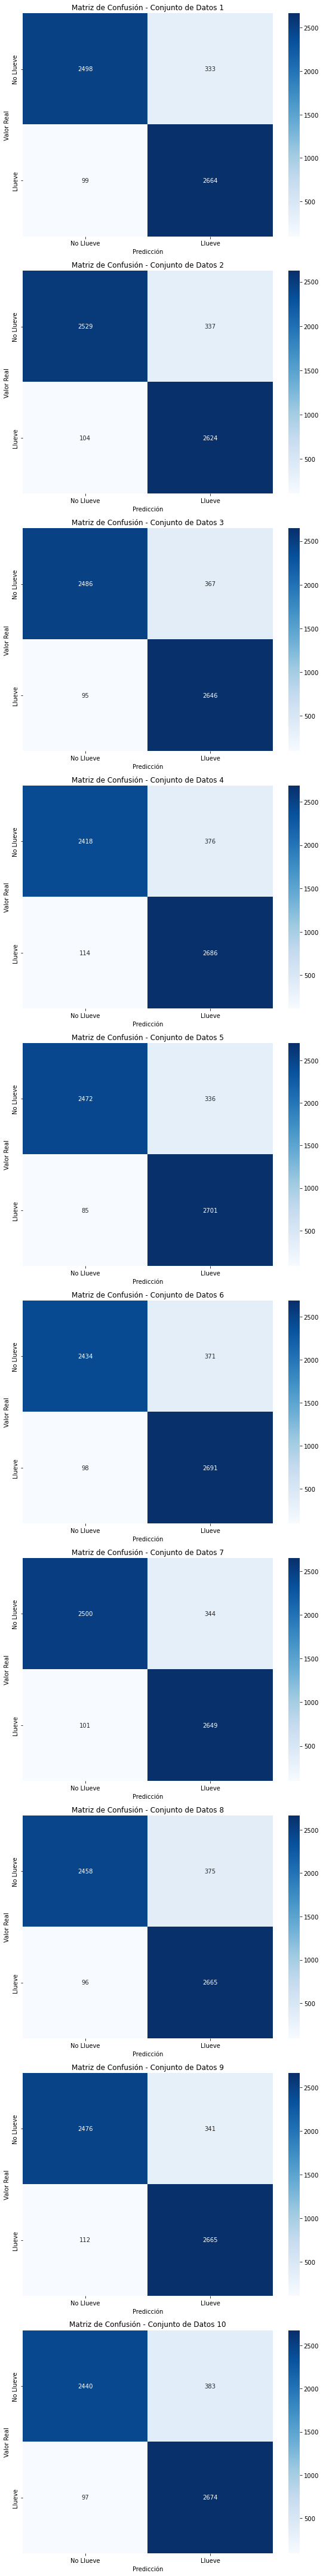

In [473]:
# Creamos una figura con subgráficos para cada matriz de confusión
fig, axs = plt.subplots(nrows=len(scores), figsize=(8, 6 * len(scores)))

# Recorremos las listas de scores
for i, (y_true, y_pred) in enumerate(scores):
    # Calculamos la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Graficamos la matriz de confusión en el subgráfico correspondiente
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Llueve', 'Llueve'], yticklabels=['No Llueve', 'Llueve'], ax=ax)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor Real')
    ax.set_title(f'Matriz de Confusión - Conjunto de Datos {i+1}')

# Ajustamos el espaciado entre los subgráficos
plt.tight_layout()
plt.show()

#### *Etapa 7: Aumentamos los datos de entrenamiento con Data Augmentation*

In [474]:
def data_augmentation_continuous(X, y, noise_std=0.1, jitter_factor=0.1, scale_factor=1.1, shift_offset=0.1):
    """
    Aplica aumentos de datos a un conjunto de datos continuos.

    Parámetros:
    - X: Array numpy con las características.
    - y: Array numpy con las etiquetas.
    - noise_std: Desviación estándar del ruido gaussiano a agregar.
    - jitter_factor: Factor de jittering para agregar perturbaciones aleatorias.
    - scale_factor: Factor de escala para aplicar transformación lineal de escala.
    - shift_offset: Valor de desplazamiento para aplicar transformación lineal de traslación.

    Retorna:
    - X_augmented: Conjunto de datos aumentado.
    - y_augmented: Etiquetas aumentadas.
    """
    # Añadir ruido
    X_noisy = X + np.random.normal(0, noise_std, size=X.shape)

    # Jittering
    X_jittered = X_noisy + np.random.uniform(-jitter_factor, jitter_factor, size=X.shape)

    # Transformación lineal de escala
    X_scaled = X_jittered * scale_factor

    # Transformación lineal de traslación
    X_shifted = X_scaled + shift_offset

    # Concatenamos datos originales con datos aumentados
    X_augmented = np.vstack([X, X_noisy, X_jittered, X_scaled, X_shifted])
    y_augmented = np.concatenate([y] * 5)  # Repetimos las etiquetas para los datos aumentados

    return X_augmented, y_augmented

# Aumentamos nuestros datos
X_rain_aug, Y_rain_aug = data_augmentation_continuous(X_rain, Y_rain)

# Eliminamos los datos originales de los aumentados
X_augmented_without_original = X_rain_aug[num_original_samples:, :]
Y_augmented_without_original = Y_rain_aug[num_original_samples:]

# Vemos su tamaño después del aumento sin los originales
print(f'Datos reales: X: {X_rain.shape}. Y: {Y_rain.shape}\nDatos aumentados sin originales: X: {X_augmented_without_original.shape}. Y: {Y_augmented_without_original.shape}')

Datos reales: X: (24860, 21). Y: (24860,)
Datos aumentados sin originales: X: (99440, 21). Y: (99440,)


#### *Etapa 8: Prueba definitiva con el mejor modelo e hiperparámetros*

In [478]:
# Lista para guardar los scores
scores_aug = []

# Creamos una instancia de KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Separamos en conjuntos de entrenamiento y prueba según los índices del KFold
# en los datos aumentados sin los originales
for train_index, test_index in kf.split(X_augmented_without_original):
    X_train, X_test = X_augmented_without_original[train_index], X_augmented_without_original[test_index]
    y_train, y_test = Y_augmented_without_original[train_index], Y_augmented_without_original[test_index]

    # Creamos una instancia de la Red Neuronal
    nn_tensorflow_rain = NeuralNetworkTensorFlow(lr=grid_search.best_estimator_.get_params()['lr'], epochs=500)

    # Entrenamos el modelo
    nn_tensorflow_rain.fit(X_train, y_train, X_test=X_test, y_test=y_test)

    # Obtenemos la predicción en el conjunto de validación
    y_pred = nn_tensorflow_rain.predict(X_rain_float)

    # Guardamos las predicciones y los valores reales
    score = [Y_rain_float, y_pred]
    scores_aug.append(score)
    
# Aviso
print('Se terminó el entrenamiento.')

LR: 0.0001, Total Epochs: 500

Epoch 0. Train Loss: 0.59908, Train Accuracy: 0.65952. Test Loss: 0.68224 Test Accuracy: 0.70304.
Epoch 100. Train Loss: 0.13603, Train Accuracy: 0.94991. Test Loss: 0.13327 Test Accuracy: 0.95344.
Epoch 200. Train Loss: 0.01342, Train Accuracy: 0.99668. Test Loss: 0.00619 Test Accuracy: 0.99960.
Epoch 300. Train Loss: 0.00390, Train Accuracy: 0.99916. Test Loss: 0.00123 Test Accuracy: 0.99990.
Epoch 400. Train Loss: 0.00206, Train Accuracy: 0.99951. Test Loss: 0.00035 Test Accuracy: 1.00000.
LR: 0.0001, Total Epochs: 500

Epoch 0. Train Loss: 0.66898, Train Accuracy: 0.61949. Test Loss: 0.52677 Test Accuracy: 0.74678.
Epoch 100. Train Loss: 0.14511, Train Accuracy: 0.94709. Test Loss: 0.15026 Test Accuracy: 0.94751.
Epoch 200. Train Loss: 0.01474, Train Accuracy: 0.99632. Test Loss: 0.00995 Test Accuracy: 0.99829.
Epoch 300. Train Loss: 0.00433, Train Accuracy: 0.99891. Test Loss: 0.00274 Test Accuracy: 0.99940.
Epoch 400. Train Loss: 0.00245, Train Accu

#### *Etapa 9: Mostrar resultados del modelo*

In [479]:
# Definimos las columnas de la tabla
columns = ['Split', 'Accuracy', 'F1-Score (Clase 0)', 'F1-Score (Clase 1)']

# Creamos una instancia de PrettyTable
table = PrettyTable(columns)

# Listas para almacenar las métricas de cada división
accuracy_scores = []
f1_scores_0 = []
f1_scores_1 = []

# Recorremos las listas de scores
for i, sublist in enumerate(scores_aug):
    predictions = sublist[0]  # Guardamos las predicciones
    real_values = sublist[1]  # Guardamos los valores reales

    # Calculamos las métricas
    accuracy = accuracy_score(real_values, predictions)
    f1_0 = f1_score(real_values, predictions, pos_label=0)
    f1_1 = f1_score(real_values, predictions, pos_label=1)

    # Almacenamos las métricas en las listas
    accuracy_scores.append(accuracy)
    f1_scores_0.append(f1_0)
    f1_scores_1.append(f1_1)

    # Añadimos la fila a la tabla
    table.add_row([f'Split {i + 1}', f'{accuracy:.5f}', f'{f1_0:.5f}', f'{f1_1:.5f}'])

# Calculamos los promedios
accuracy_mean = np.mean(accuracy_scores)
f1_0_mean = np.mean(f1_scores_0)
f1_1_mean = np.mean(f1_scores_1)

# Añadimos la fila de promedios a la tabla
table.add_row(["Promedio", f'{accuracy_mean:.5f}', f'{f1_0_mean:.5f}', f'{f1_1_mean:.5f}'])

# Mostramos la tabla
print(table)

+----------+----------+--------------------+--------------------+
|  Split   | Accuracy | F1-Score (Clase 0) | F1-Score (Clase 1) |
+----------+----------+--------------------+--------------------+
| Split 1  | 0.99791  |      0.99790       |      0.99791       |
| Split 2  | 0.99743  |      0.99742       |      0.99743       |
| Split 3  | 0.99819  |      0.99819       |      0.99819       |
| Split 4  | 0.99831  |      0.99831       |      0.99831       |
| Split 5  | 0.99714  |      0.99714       |      0.99715       |
| Split 6  | 0.99722  |      0.99722       |      0.99723       |
| Split 7  | 0.99771  |      0.99770       |      0.99771       |
| Split 8  | 0.99755  |      0.99754       |      0.99755       |
| Split 9  | 0.99815  |      0.99815       |      0.99815       |
| Split 10 | 0.99767  |      0.99766       |      0.99767       |
| Promedio | 0.99773  |      0.99772       |      0.99773       |
+----------+----------+--------------------+--------------------+


#### *Etapa 10: Matriz de Confusión*

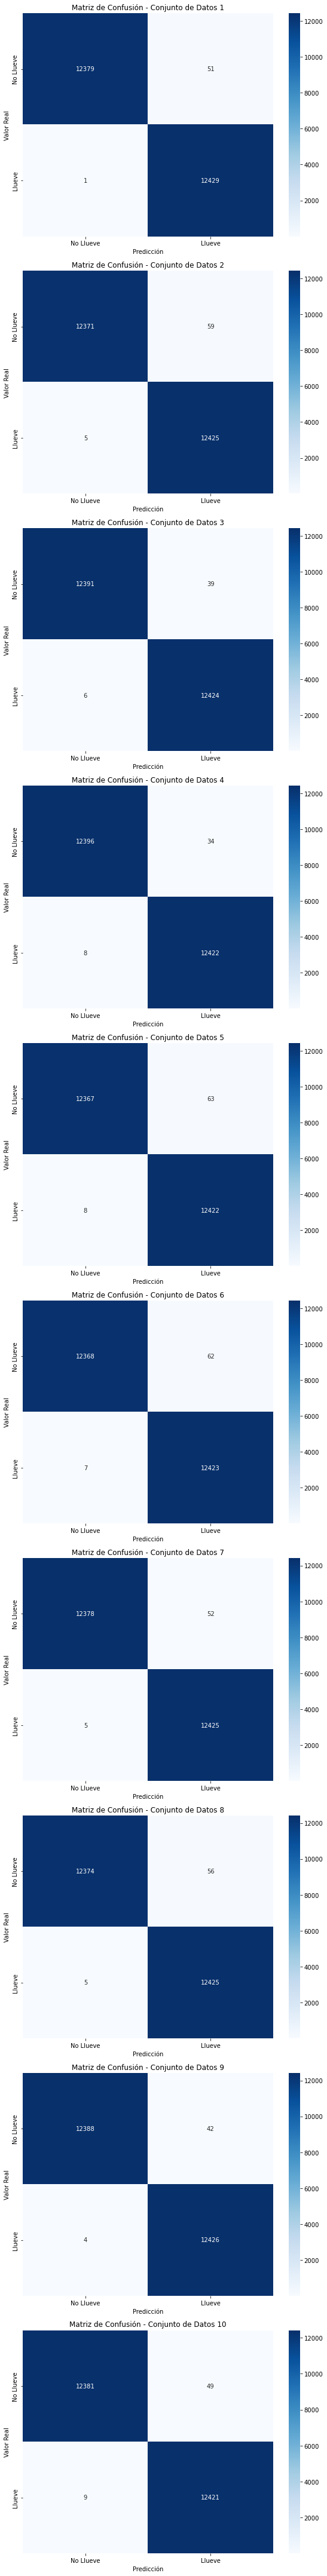

In [480]:
# Creamos una figura con subgráficos para cada matriz de confusión
fig, axs = plt.subplots(nrows=len(scores_aug), figsize=(8, 6 * len(scores_aug)))

# Recorremos las listas de scores
for i, (y_true, y_pred) in enumerate(scores_aug):
    # Calculamos la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Graficamos la matriz de confusión en el subgráfico correspondiente
    ax = axs[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Llueve', 'Llueve'], yticklabels=['No Llueve', 'Llueve'], ax=ax)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor Real')
    ax.set_title(f'Matriz de Confusión - Conjunto de Datos {i+1}')

# Ajustamos el espaciado entre los subgráficos
plt.tight_layout()
plt.show()